# NLP'ye Giri≈ü

Doƒüal dil i≈ülemenin (NLP) temel amacƒ±, doƒüal dilden bilgi elde etmektir. Doƒüal dil geni≈ü bir terimdir ancak a≈üaƒüƒ±dakilerden herhangi birini kapsadƒ±ƒüƒ±nƒ± d√º≈ü√ºnebilirsiniz:

- Metin (bir e-postada, blog g√∂nderisinde, kitapta, Tweette bulunanlar gibi)
- Konu≈üma (bir doktorla yaptƒ±ƒüƒ±nƒ±z konu≈üma, telefonuna verdiƒüiniz sesli komutlar)

Metin ve konu≈üma ≈üemsiyesi altƒ±nda yapmak isteyebileceƒüiniz bir√ßok farklƒ± ≈üey var. Bir e-posta uygulamasƒ± olu≈üturuyorsanƒ±z, spam olup olmadƒ±klarƒ±nƒ± (sƒ±nƒ±flandƒ±rma) g√∂rmek i√ßin gelen e-postalarƒ± taramak isteyebilirsiniz.

M√º≈üteri geri bildirim ≈üikayetlerini analiz etmeye √ßalƒ±≈üƒ±yorsanƒ±z, bunlarƒ±n i≈ületmenizin hangi b√∂l√ºm√º i√ßin olduƒüunu ke≈üfetmek isteyebilirsiniz.

> üîë Not: Bu t√ºr verilerin her ikisine de genellikle diziler denir (bir c√ºmle, bir s√∂zc√ºk dizisidir). Bu nedenle, NLP problemlerinde kar≈üƒ±la≈üacaƒüƒ±nƒ±z yaygƒ±n bir terime **seq2seq** denir, ba≈üka bir deyi≈üle, bir dizideki bilgiyi ba≈üka bir dizi olu≈üturmak i√ßin bulmak (√∂rneƒüin, bir konu≈üma komutunu metin tabanlƒ± adƒ±mlar dizisine d√∂n√º≈üt√ºrmek).

TensorFlow'da NLP ile pratik yapmak i√ßin daha √∂nce kullandƒ±ƒüƒ±mƒ±z adƒ±mlarƒ± bu sefer metin verileriyle uygulayacaƒüƒ±z:

```
Metin -> sayƒ±lara d√∂n√º≈üt√ºr√ºn -> bir model olu≈üturun -> modeli kalƒ±plarƒ± bulmak i√ßin eƒüitin -> kalƒ±plarƒ± kullanƒ±n (tahminlerde bulunun)
```

## ƒ∞√ßerik: 

- Bir metin veri k√ºmesini indirme
- Metin verilerini g√∂rselle≈ütirme
- Tokenization kullanarak metni sayƒ±lara d√∂n√º≈üt√ºrme
- Belirtilmi≈ü metnimizi bir g√∂mmeye d√∂n√º≈üt√ºrmek
- Bir metin veri k√ºmesini modelleme
  - Temel ile ba≈ülama (TF-IDF)
  - Birka√ß derin √∂ƒürenme metin modeli olu≈üturma
    - Yoƒüun, LSTM, GRU, Conv1D, Aktarƒ±m √∂ƒürenimi
- Her bir modelimizin performansƒ±nƒ± kar≈üƒ±la≈ütƒ±rma
- Modellerimizi bir toplulukta birle≈ütirmek
- Eƒüitilmi≈ü bir modeli kaydetme ve y√ºkleme
- En yanlƒ±≈ü tahminleri bulunma

---

Eƒüitime ba≈ülamadan √∂nce gerekli fonksiyonlarƒ± olu≈üturalƒ±m.

In [1]:
import zipfile
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [3]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [5]:
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Veri K√ºmesini ƒ∞ndirme

Bir metin veri k√ºmesi indirerek ba≈ülayalƒ±m. [Real or Not](https://www.kaggle.com/c/nlp-getting-started/data)'u kullanacaƒüƒ±z. Doƒüal afetler hakkƒ±nda metin tabanlƒ± Tweetler i√ßeren Kaggle sitesinde bulunan veri seti.

**Ger√ßek Tweetler** aslƒ±nda felaketlerle ilgilidir, √∂rneƒüin:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

**Ger√ßek Olmayan Tweetler**, felaketlerle ilgili olmayan Tweetlerdir (her konuda olabilir), √∂rneƒüin:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

In [7]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-08-01 15:36:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‚Äònlp_getting_started.zip‚Äô

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-08-01 15:36:28 (146 MB/s) - ‚Äònlp_getting_started.zip‚Äô saved [607343/607343]



`nlp_getting_started.zip` dosyasƒ±nda 3 farklƒ± csv belgesi vardƒ±r: Bunlar: 

- **sample_submission.csv** 
Modelinizin tahminlerini i√ßeren Kaggle yarƒ±≈ümasƒ±na g√∂ndereceƒüiniz dosyanƒ±n bir √∂rneƒüi.
- **train.csv**
Ger√ßek ve ger√ßek olmayan felaket Tweetlerinin eƒüitim √∂rnekleri.
- **test.csv**
Ger√ßek ve ger√ßek olmayan felaket Tweet √∂rneklerinin test edilmesi i√ßin √∂rnekler.

<img src="https://boostlabs.com/wp-content/uploads/2019/09/10-types-of-data-visualization-1.jpg" />

## Bir Metin Veri K√ºmesini G√∂rselle≈ütirme

√áalƒ±≈ümak i√ßin yeni bir veri k√ºmesi edindikten sonra, √∂nce ne yapmalƒ±sƒ±nƒ±z? Ke≈üfetmek mi? Kontrol et? Doƒürula? Onunla bir olmak mƒ±? Hepsi doƒüru :)

Sloganƒ± hatƒ±rlayƒ±n: g√∂rselle≈ütirin, g√∂rselle≈ütirin, g√∂rselle≈ütirin.

≈ûu anda metin veri √∂rneklerimiz .csv dosyalarƒ± bi√ßimindedir. Onlarƒ± g√∂rsel hale getirmenin kolay bir yolu i√ßin onlarƒ± pandas DataFrame'e √ßevirelim.

> üìñ Okuma: Bir√ßok farklƒ± formatta metin veri setleriyle kar≈üƒ±la≈üabilirsiniz. CSV dosyalarƒ±nƒ±n (√ºzerinde √ßalƒ±≈ütƒ±ƒüƒ±mƒ±z ≈üey) yanƒ± sƒ±ra, muhtemelen .txt dosyalarƒ± ve .json dosyalarƒ±yla da kar≈üƒ±la≈üacaksƒ±nƒ±z. Bu t√ºr dosyalarla √ßalƒ±≈ümak i√ßin RealPython'un a≈üaƒüƒ±daki iki makalesini okumanƒ±zƒ± tavsiye ederim:

- [Python'da Dosyalar Nasƒ±l Okunur ve Yazƒ±lƒ±r](https://realpython.com/read-write-files-python/)
- [Python'da JSON Verileriyle √áalƒ±≈ümak](https://realpython.com/python-json/)

In [8]:
# .csv dosyalarƒ±nƒ± pandas DataFrame'lerine d√∂n√º≈üt√ºr√ºn
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

ƒ∞ndirdiƒüimiz eƒüitim verileri muhtemelen zaten karƒ±≈ütƒ±rƒ±lmƒ±≈ütƒ±r. Ama emin olmak i√ßin tekrar karƒ±≈ütƒ±ralƒ±m.

In [9]:
train_df_shuffled = train_df.sample(frac=1, random_state=42) 
train_df_shuffled.head()

id  ... target
2644  3796  ...      1
2227  3185  ...      0
5448  7769  ...      1
132    191  ...      0
6845  9810  ...      0

[5 rows x 5 columns]

Eƒüitim verilerinin nasƒ±l bir `"target"` s√ºtunu olduƒüuna dikkat edin.

`"target"` s√ºtununun deƒüerini tahmin etmek i√ßin eƒüitim veri k√ºmesinin `"text"` s√ºtununda kalƒ±plarƒ± (√∂rneƒüin farklƒ± kelime kombinasyonlarƒ±) bulmak i√ßin kod yazacaƒüƒ±z. Test veri k√ºmesinin bir `"target"` s√ºtunu yok.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

In [10]:
# Test verilerinin bir hedefi yok (tahmin etmeye √ßalƒ±≈ütƒ±ƒüƒ±mƒ±z ≈üey bu)
test_df.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

Her hedeften ka√ß tane √∂rneƒüimiz olduƒüunu kontrol edelim.

In [11]:
# Her sƒ±nƒ±ftan ka√ß √∂rnek var?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

ƒ∞ki sƒ±nƒ±f deƒüeri olduƒüundan, `binary_classification` problemiyle uƒüra≈üacaƒüƒ±z gibi duruyor. Veri setimizi incelediƒüimizde dengeli bir daƒüƒ±lƒ±m g√∂r√ºyoruz. %60 olumsuz, %40 olumlu sƒ±nƒ±f i√ßeriyor.

- 1: ger√ßek bir felaket twet'i
- 0: ger√ßek olmayan bir felaket twet'i

Peki elimizde ki toplam √∂rnek sayƒ±sƒ± ka√ß?

In [12]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Pekala, yeterli miktarda eƒüitim ve test verisine sahibiz gibi g√∂r√ºn√ºyor. G√∂rselle≈ütirme zamanƒ±, hadi rastgele metin √∂rneklerini g√∂rselle≈ütirmek i√ßin bazƒ± kodlar yazalƒ±m.

> **ü§î Soru:** Rastgele √∂rnekleri neden g√∂rselle≈ütirelim? √ñrnekleri sƒ±rayla g√∂rselle≈ütirebilirsiniz, ancak bu yalnƒ±zca belirli bir veri alt k√ºmesini g√∂rmenize neden olabilir. √úzerinde √ßalƒ±≈ütƒ±ƒüƒ±nƒ±z farklƒ± veri t√ºrleri hakkƒ±nda bir fikir edinmek i√ßin √∂nemli miktarda (100+) rastgele √∂rneƒüi g√∂rselle≈ütirmek daha iyidir. Makine √∂ƒüreniminde rastgeleliƒüin g√ºc√ºn√º asla hafife almayƒ±n.

In [13]:
import random
random_index = random.randint(0, len(train_df)-5) 
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
catastrophic-fallen-angel: reveillertm: macabrelolita: I was supposed to write ¬â√õ√∑amino acids¬â√õ¬™ and I nearly... http://t.co/dIoBzGHFju

---

Target: 0 (not real disaster)
Text:
'if you can't summon the flames directly from hell store bought is fine'-me 
mom-*dies*

---

Target: 0 (not real disaster)
Text:
Back in 02 to 03 would never said that 50 would have ended ja like obliteration

---

Target: 0 (not real disaster)
Text:
How can we help save a beautiful town in Ontario from destruction by a power plant developer?
http://t.co/hlD5xLYwBn

---

Target: 0 (not real disaster)
Text:
that exploded &amp; brought about the
beginning of universe matches what's
mentioned in the versethe heaven and Earth
(thus the universe)

---



## Verileri Eƒüitim ve Doƒürulama K√ºmelerine Ayƒ±rƒ±n

Test setinde etiket olmadƒ±ƒüƒ±ndan ve eƒüitilmi≈ü modellerimizi deƒüerlendirmek i√ßin bir yola ihtiyacƒ±mƒ±z olduƒüundan, eƒüitim verilerinden bazƒ±larƒ±nƒ± ayƒ±racaƒüƒ±z ve bir doƒürulama seti olu≈üturacaƒüƒ±z.

Modelimiz eƒüitildiƒüinde (Tweet √∂rneklerindeki kalƒ±plarƒ± denediƒüinde), yalnƒ±zca eƒüitim k√ºmesindeki verileri g√∂r√ºr ve doƒürulama k√ºmesini kullanarak g√∂r√ºnmeyen veriler √ºzerinde nasƒ±l performans g√∂sterdiƒüini g√∂rebiliriz.

Pandas Series veri t√ºrlerinden b√∂lmelerimizi daha sonra kullanƒ±m kolaylƒ±ƒüƒ± i√ßin string listelerine (metin i√ßin) ve ints listelerine (etiketler i√ßin) d√∂n√º≈üt√ºreceƒüiz.

Eƒüitim veri setimizi b√∂lmek ve bir doƒürulama veri seti olu≈üturmak i√ßin Scikit-Learn'in `train_test_split()` y√∂ntemini kullanacaƒüƒ±z ve eƒüitim √∂rneklerinin %10'unu doƒürulama setine ayƒ±racaƒüƒ±z.

In [14]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [16]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Metni Sayƒ±lara d√∂n√º≈üt√ºrme

Tweetler ve etiketler i√ßeren bir eƒüitim setimiz ve bir doƒürulama setimiz var. Etiketlerimiz sayƒ±sal (0 ve 1) bi√ßimindedir, ancak Tweetlerimiz dize bi√ßimindedir.

> ü§î Soru: Metin verilerimizle bir makine √∂ƒürenmesi algoritmasƒ± kullanabilmemiz i√ßin sizce ne yapmamƒ±z gerekiyor?

"Sayƒ±ya √ßevir" gibi bir cevap verdiyseniz, haklƒ±sƒ±nƒ±z. Bir makine √∂ƒürenimi algoritmasƒ±, girdilerinin sayƒ±sal bi√ßimde olmasƒ±nƒ± gerektirir.

NLP'de metni sayƒ±lara d√∂n√º≈üt√ºrmek i√ßin iki ana kavram vardƒ±r:

- **Tokenization**<br>
Kelimeden veya karakterden veya alt kelimeden sayƒ±sal bir deƒüere d√ºz bir e≈üleme. √ú√ß ana tokenizasyon seviyesi vardƒ±r:
  1. Kelime d√ºzeyinde simgele≈ütirmeyi "I love TensorFlow" c√ºmlesiyle kullanmak, "I"nin 0, "love"  1 ve "TensorFlow"un 2 olmasƒ±na neden olabilir. Bu durumda, bir dizideki her s√∂zc√ºk tek bir simge olarak kabul edilir.
  2. A-Z harflerini 1-26 deƒüerlerine d√∂n√º≈üt√ºrmek gibi karakter d√ºzeyinde simgele≈ütirme. Bu durumda, bir dizideki her karakter tek bir simge olarak kabul edilir.
  3. Alt s√∂zc√ºk belirleme, s√∂zc√ºk d√ºzeyinde ve karakter d√ºzeyinde simgele≈ütirme arasƒ±ndadƒ±r. Tek tek kelimeleri daha k√º√ß√ºk par√ßalara ayƒ±rmayƒ± ve ardƒ±ndan bu daha k√º√ß√ºk par√ßalarƒ± sayƒ±lara d√∂n√º≈üt√ºrmeyi i√ßerir. √ñrneƒüin, "my favorite food is pineapple pizza", "my, favor, rite, fo, oo, od, is, pin, ine, app, le, piz, za" olabilir. Bunu yaptƒ±ktan sonra, bu alt kelimeler daha sonra sayƒ±sal bir deƒüere e≈ülenir. Bu durumda, her kelime birden fazla belirte√ß olarak kabul edilebilir.

- **Embedding**<br>
Embed, √∂ƒürenilebilen doƒüal dilin bir temsilidir. Temsil, bir √∂zellik vekt√∂r√º ≈üeklinde gelir. √ñrneƒüin, "dance" kelimesi 5 boyutlu vekt√∂r [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112] ile temsil edilebilir. Burada not etmek √∂nemlidir, √∂zellik vekt√∂r√ºn√ºn boyutu ayarlanabilir. Embed kullanmanƒ±n iki yolu vardƒ±r:
  1. Kendi embed i≈üleminizi olu≈üturun - Metniniz sayƒ±lara d√∂n√º≈üt√ºr√ºld√ºƒü√ºnde (embed i√ßin gereklidir), onlarƒ± bir embed  katmanƒ±na (tf.keras.layers.Embedding gibi) koyabilirsiniz ve model eƒüitimi sƒ±rasƒ±nda bir embed g√∂sterimi √∂ƒürenilecektir.
  2. √ñnceden √∂ƒürenilmi≈ü bir yerle≈ütirmeyi yeniden kullanƒ±n - √áevrimi√ßi olarak √∂nceden eƒüitilmi≈ü bir√ßok yerle≈ütirme mevcuttur. Bu √∂nceden eƒüitilmi≈ü yerle≈ütirmeler genellikle b√ºy√ºk metin k√ºtlelerinde (t√ºm Wikipedia'da olduƒüu gibi) √∂ƒürenilmi≈ütir ve bu nedenle doƒüal dilin iyi bir temel temsiline sahiptir. Modelinizi ba≈ülatmak ve kendi √∂zel g√∂revinize g√∂re ince ayar yapmak i√ßin √∂nceden eƒüitilmi≈ü bir yerle≈ütirme kullanabilirsiniz.

> Soru: Hangi d√ºzeyde belirte√ß kullanmalƒ±yƒ±m? Hangi embedi  se√ßmeliyim?

Sorununuza baƒülƒ±. Karakter d√ºzeyinde tokenization/embed ve s√∂zc√ºk d√ºzeyinde word-level-tokenization/embed deneyebilir ve hangisinin en iyi performansƒ± g√∂sterdiƒüini g√∂rebilirsiniz. Bunlarƒ± istiflemeyi bile deneyebilirsiniz (√∂rneƒüin, embed katmanlarƒ±nƒ±zƒ±n √ßƒ±ktƒ±larƒ±nƒ± tf.keras.layers.concatenate kullanarak birle≈ütirmek).

√ñnceden eƒüitilmi≈ü s√∂zc√ºk yerle≈ütirmeleri arƒ±yorsanƒ±z, Word2vec yerle≈ütirmeleri, GloVe yerle≈ütirmeleri ve TensorFlow Hub'da bulunan se√ßeneklerin √ßoƒüu, ba≈ülamak i√ßin harika yerlerdir.

> üîë Not: √ñnceden eƒüitilmi≈ü bir bilgisayarlƒ± g√∂r√º modelini aramaya benzer ≈üekilde, probleminiz i√ßin kullanmak √ºzere √∂nceden eƒüitilmi≈ü s√∂zc√ºk yerle≈ütirmelerini arayabilirsiniz. "TensorFlow'da √∂nceden eƒüitilmi≈ü kelime yerle≈ütirmelerini kullan" gibi bir ≈üey aramayƒ± deneyin.

### Metin Vekt√∂rle≈ütirme

ƒ∞lk √∂nce tokenizasyon (kelimelerimizi sayƒ±larla e≈üle≈ütirme) alƒ±≈ütƒ±rmasƒ± yapacaƒüƒ±z. S√∂zlerimizi simgele≈ütirmek i√ßin, yararlƒ± √∂ni≈üleme katmanƒ± `tf.keras.layers.experimental.preprocessing.TextVectorization` kullanacaƒüƒ±z.

TextVectorization katmanƒ± a≈üaƒüƒ±daki parametreleri alƒ±r:
- **max_tokens**<br>
Kelime daƒüarcƒ±ƒüƒ±nƒ±zdaki maksimum kelime sayƒ±sƒ± (√∂rneƒüin, metninizdeki 20000 veya benzersiz kelime sayƒ±sƒ±), OOV (kelime dƒ±≈üƒ±) belirte√ßleri i√ßin bir deƒüer i√ßerir.
- **standardize**<br>
Metni standartla≈ütƒ±rma y√∂ntemi. Varsayƒ±lan, metni al√ßaltan ve t√ºm noktalama i≈üaretlerini kaldƒ±ran "`lower_and_strip_punctuation`"dƒ±r.
- **split**<br>
Metin nasƒ±l b√∂l√ºn√ºr, varsayƒ±lan olarak bo≈üluklara b√∂l√ºnen "split"tir.
- **ngrams**<br>
Belirte√ß ba≈üƒ±na ka√ß s√∂zc√ºk i√ßerecek, √∂rneƒüin, ngrams=2 belirte√ßleri 2'lik s√ºrekli dizilere b√∂ler.
- **output_mode**<br>
Belirte√ßler nasƒ±l √ßƒ±karƒ±lƒ±r, "int" (tamsayƒ± e≈üleme), "binary" (tek-sƒ±cak kodlama), "count" veya "tf-idf" olabilir. 
- **output_sequence_length**<br>
√áƒ±ktƒ± i√ßin belirtilmi≈ü dizinin uzunluƒüu. √ñrneƒüin, √ßƒ±ktƒ±_dizi_uzunluk=150 ise, t√ºm belirte√ßli diziler 150 belirte√ß uzunluƒüunda olacaktƒ±r.
- **pad_to_max_tokens**<br>
True (varsayƒ±lan) ise, s√∂zl√ºkteki benzersiz jeton sayƒ±sƒ± max_tokens'den az olsa bile √ßƒ±ktƒ± √∂zelliƒüi ekseni max_tokens olarak doldurulur.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

Bir TextVectorization nesnesini varsayƒ±lan ayarlarla ba≈ülattƒ±k, ancak bunu kendi kullanƒ±m durumumuz i√ßin biraz √∂zelle≈ütirelim. √ñzellikle `max_tokens` ve `output_sequence_length` i√ßin deƒüerler belirleyelim.

`max_tokens` (kelimelerdeki kelime sayƒ±sƒ±) i√ßin 10.000'in katlarƒ± (10.000, 20.000, 30.000) veya metninizdeki tam benzersiz kelime sayƒ±sƒ± (√∂r. 32.179) ortak deƒüerlerdir. Kullanƒ±m durumumuz i√ßin 10.000 kullanacaƒüƒ±z.

Ve `output_sequence_length` i√ßin, eƒüitim setindeki Tweet ba≈üƒ±na ortalama jeton sayƒ±sƒ±nƒ± kullanacaƒüƒ±z. Ama √∂nce onu bulmamƒ±z gerekecek.

In [18]:
# Eƒüitim Tweetlerinde ortalama jeton (kelime) sayƒ±sƒ±nƒ± bulma
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

≈ûimdi √∂zel parametrelerimizi kullanarak ba≈üka bir TextVectorization nesnesi olu≈üturalƒ±m.

In [19]:
# Metin vekt√∂rle≈ütirme deƒüi≈ükenlerini ayarlayƒ±n
max_vocab_length = 10000 # kelime daƒüarcƒ±ƒüƒ±mƒ±zda bulunmasƒ± gereken maksimum kelime sayƒ±sƒ±
max_length = 15 # dizilerimiz maksimum uzunluk olacaktƒ±r (√∂r. modelimiz bir Tweetten ka√ß kelime g√∂r√ºyor?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

G√ºzel! `TextVectorization` √∂rneƒüimizi text_vectorizer verilerimizle e≈üle≈ütirmek i√ßin, eƒüitim metnimizi iletirken `adapt()` y√∂ntemini √ßaƒüƒ±rabiliriz.

In [20]:
# Metin vekt√∂rle≈ütiriciyi eƒüitim metnine fit etme
text_vectorizer.adapt(train_sentences)

Eƒüitim verileri e≈ülendi! Text_vectorizer'ƒ±mƒ±zƒ± √∂zel bir c√ºmle √ºzerinde deneyelim (eƒüitim verilerinde g√∂rebileceƒüinize benzer bir c√ºmle).

In [21]:
# √ñrnek c√ºmle olu≈ütur ve onu belirt
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Harika, g√∂r√ºn√º≈üe g√∂re metnimizi sayƒ±lara d√∂n√º≈üt√ºrmenin bir yolu var (bu durumda, kelime d√ºzeyinde simgele≈ütirme). D√∂nd√ºr√ºlen tens√∂r√ºn sonundaki 0'lara dikkat edin, bunun nedeni output_sequence_length=15 olarak ayarlamƒ±≈ü olmamƒ±zdƒ±r, yani text_vectorizer'a ilettiƒüimiz dizinin boyutu ne olursa olsun, her zaman 15 uzunluƒüunda bir dizi d√∂nd√ºr√ºr.

Birka√ß rastgele c√ºmle √ºzerinde text_vectorizer'ƒ±mƒ±zƒ± denemeye ne dersiniz?

In [22]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
U.S. Forest Service firefighter David Ruhl 38 died in the 'Frog Fire' in the Modoc National Forest. He had been temporarily reassigned      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  69,  188,  386, 1674, 1691, 8927,    1,  579,    4,    2,    1,
          42,    4,    2,    1]])>

ƒ∞yi g√∂r√ºn√ºyor! Son olarak, `get_vocabulary()` y√∂ntemini kullanarak s√∂zl√ºƒü√ºm√ºzdeki benzersiz belirte√ßleri kontrol edebiliriz.

In [23]:
# Kelime daƒüarcƒ±ƒüƒ±ndaki benzersiz kelimeleri alƒ±n
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:] 
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


G√∂mme Katmanƒ± Kullanarak G√∂mme Olu≈üturma
Metnimizi sayƒ±larla e≈üle≈ütirmenin bir yolu var. Bir adƒ±m daha ileri gidip bu sayƒ±larƒ± bir g√∂mme haline getirmeye ne dersiniz?

Bir g√∂mmenin g√º√ßl√º yanƒ±, eƒüitim sƒ±rasƒ±nda √∂ƒürenilebilmesidir. Bu, yalnƒ±zca statik olmaktan ziyade (√∂rneƒüin 1 = I, 2 = love, 3 = TensorFlow), bir kelimenin sayƒ±sal g√∂steriminin, bir model veri √∂rneklerinden ge√ßerken geli≈ütirilebileceƒüi anlamƒ±na gelir.

`tf.keras.layers.Embedding` katmanƒ±nƒ± kullanarak bir kelimenin g√∂m√ºlmesinin nasƒ±l g√∂r√ºnd√ºƒü√ºn√º g√∂rebiliriz.

Burada ilgilendiƒüimiz ana parametreler ≈üunlardƒ±r:

- **input_dim** <br>
S√∂zl√ºƒü√ºn boyutu 
- **output_dim**<br>
√áƒ±ktƒ± g√∂mme vekt√∂r√ºn√ºn boyutu, √∂rneƒüin 100 deƒüeri, her kelime i√ßin 100 boyutunda bir √∂zellik vekt√∂r√º verir.
- **embeddings_initializer**<br>
G√∂mme matrisi nasƒ±l ba≈ülatƒ±lƒ±r, varsayƒ±lan deƒüer, tek tip daƒüƒ±lƒ±mla g√∂mme matrisini rastgele ba≈ülatan "tek bi√ßimli"dir. Bu, √∂nceden √∂ƒürenilmi≈ü yerle≈ütirmeleri kullanmak i√ßin deƒüi≈ütirilebilir.
- **input_length**<br> G√∂mme katmanƒ±na ge√ßirilen dizilerin uzunluƒüu.

Bunlarƒ± bilerek bir g√∂mme katmanƒ± yapalƒ±m.

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128, 
                             embeddings_initializer="uniform",
                             input_length=max_length) 

embedding

M√ºkemmel, TensoFlow katmanƒ±nƒ±n nasƒ±l g√∂m√ºld√ºƒü√ºn√º fark ettiniz mi? Bu √∂nemlidir √ß√ºnk√º onu bir modelin par√ßasƒ± olarak kullanabiliriz, yani parametreleri (kelime temsilleri) model √∂ƒürendik√ße g√ºncellenebilir ve geli≈ütirilebilir.

√ñrnek bir c√ºmle √ºzerinde deneyelim mi?

In [25]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Army names 10th Mountain units for Iraq Afghanistan deployments (Deeds) http://t.co/N6ZfLXIGvr      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00916288, -0.02020576,  0.01051251, ...,  0.03743795,
         -0.03013742, -0.02531119],
        [ 0.04532088,  0.02299361,  0.01219423, ..., -0.00065058,
         -0.04569644, -0.00531676],
        [ 0.03858428, -0.04181042, -0.00797512, ..., -0.00329729,
          0.03181828,  0.04978368],
        ...,
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162],
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162],
        [ 0.00141954, -0.01528921,  0.04304833, ..., -0.01062925,
          0.01877917, -0.00428162]]], dtype=float32)>

C√ºmledeki her belirte√ß, 128 uzunlukta bir √∂zellik vekt√∂r√ºne d√∂n√º≈üt√ºr√ºl√ºr.

In [26]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00916288, -0.02020576,  0.01051251,  0.01018524, -0.04450629,
        0.01370009,  0.01044489, -0.01513488,  0.02855153,  0.01395481,
       -0.04568119, -0.00575911,  0.01966823, -0.04059171,  0.0413805 ,
        0.03656509, -0.02095454, -0.04788685, -0.02226297,  0.04037564,
       -0.03191366,  0.03968054, -0.00194321,  0.02069068,  0.0350836 ,
        0.02134537,  0.01469893, -0.02956121, -0.02796942, -0.03294774,
       -0.04563676, -0.03714399,  0.01066669,  0.03298349, -0.00739118,
        0.04917097,  0.01289347,  0.03903702,  0.02170446,  0.02120433,
        0.01201127, -0.01070263,  0.0261583 ,  0.03698863,  0.01283456,
       -0.01727299, -0.00012108, -0.0367375 , -0.01463311, -0.04898279,
       -0.00069792, -0.00546343,  0.02455739,  0.03335546, -0.03360651,
       -0.03045735,  0.00717491, -0.03701036, -0.01086336,  0.03041612,
       -0.01906449,  0.02496426, -0.03597245, -0.01636804, -0.00832563,
        0.035312

üîë Not: √ñnceki iki kavram (belirte√ßle≈ütirme ve yerle≈ütirme) bir√ßok NLP g√∂revinin temelidir. Bu nedenle, herhangi bir ≈üeyden emin deƒüilseniz, anlayƒ±≈üƒ±nƒ±za daha fazla yardƒ±mcƒ± olmak i√ßin kendi deneylerinizi ara≈ütƒ±rdƒ±ƒüƒ±nƒ±zdan ve y√ºr√ºtt√ºƒü√ºn√ºzden emin olun.

## Bir Metin Veri K√ºmesini Modelleme

Girdilerinizi ve √ßƒ±ktƒ±larƒ±nƒ±zƒ± hazƒ±rladƒ±ktan sonra, aradaki bo≈üluƒüu kapatmak i√ßin hangi makine √∂ƒürenimi modelinin olu≈üturulacaƒüƒ±nƒ± bulmak meselesidir.

Artƒ±k metin verilerimizi sayƒ±lara d√∂n√º≈üt√ºrmenin bir yolu olduƒüuna g√∂re, onu modellemek i√ßin makine √∂ƒürenimi modelleri olu≈üturmaya ba≈ülayabiliriz.

Bol bol pratik yapmak i√ßin, her biri kendi deneyi olan bir dizi farklƒ± model olu≈üturacaƒüƒ±z. Daha sonra her modelin sonu√ßlarƒ±nƒ± kar≈üƒ±la≈ütƒ±racaƒüƒ±z ve hangisinin en iyi performansƒ± g√∂sterdiƒüini g√∂receƒüiz.

Daha spesifik olarak, a≈üaƒüƒ±dakileri in≈üa edeceƒüiz:

- Model 0: Naive Bayes (temel)
- Model 1: ƒ∞leri beslemeli sinir aƒüƒ± (yoƒüun model)
- Model 2: LSTM modeli
- Model 3: GRU modeli
- Model 4: √áift Y√∂nl√º-LSTM modeli
- Model 5: 1B Evri≈üimli Sinir Aƒüƒ±
- Model 6: TensorFlow Hub √ñnceden Eƒüitilmi≈ü √ñzellik √áƒ±karƒ±cƒ±
- Model 7: Eƒüitim verilerinin %10 ile model 6'nƒ±n aynƒ±sƒ± 

Model 0, diƒüer daha derin modellerin birbirini yenmesini bekleyeceƒüimiz bir temel elde etmek i√ßin en basit olanƒ±dƒ±r.

Her deney a≈üaƒüƒ±daki adƒ±mlardan ge√ßecektir:

- Modeli olu≈üturun
- Modeli eƒüit
- Modelle tahminler yapƒ±n
- Daha sonra kar≈üƒ±la≈ütƒ±rma i√ßin tahmin deƒüerlendirme metriklerini takip edin

### Model 0: Temel olu≈üturma

T√ºm makine √∂ƒürenimi modelleme deneylerinde olduƒüu gibi, bir temel model olu≈üturmak √∂nemlidir, b√∂ylece gelecekteki deneyler i√ßin √ºzerine in≈üa edebileceƒüiniz bir kƒ±yaslama elde edersiniz.

Temel √ßizgimizi olu≈üturmak i√ßin, kelimelerimizi sayƒ±lara d√∂n√º≈üt√ºrmek i√ßin TF-IDF (terim frekansƒ±-ters belge frekansƒ±) form√ºl√ºn√º kullanarak bir Scikit-Learn Pipeline olu≈üturacaƒüƒ±z ve ardƒ±ndan bunlarƒ± Multinomial Naive Bayes algoritmasƒ± ile modelleyeceƒüiz. Bu, Scikit-Learn makine √∂ƒürenimi haritasƒ±na ba≈üvurularak se√ßildi.

üìñ TD-IDF algoritmasƒ± hakkƒ±nda okunmasƒ± gereken bir makale: https://www.onely.com/blog/what-is-tf-idf/

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),# tfidf kullanarak kelimeleri sayƒ±lara d√∂n√º≈üt√ºr√ºn
                    ("clf", MultinomialNB()) # metni modelle
])

model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

`Multinomial Naive Bayes` gibi sƒ±ƒü bir model kullanmanƒ±n yararƒ±, eƒüitimin √ßok hƒ±zlƒ± olmasƒ±dƒ±r. Modelimizi deƒüerlendirelim ve temel metriƒüimizi bulalƒ±m.

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


Temel modelimiz ile bazƒ± tahminler yapmaya ne dersiniz?

In [29]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Model Deneylerimiz ƒ∞√ßin Bir Deƒüerlendirme Fonksiyonu Olu≈üturma

Bunlarƒ± olduƒüu gibi deƒüerlendirebiliriz, ancak ileride birka√ß modeli aynƒ± ≈üekilde deƒüerlendireceƒüimiz i√ßin, bir dizi tahmin ve kesinlik etiketi alan ve a≈üaƒüƒ±dakileri hesaplayan bir yardƒ±mcƒ± fonksiyon olu≈üturalƒ±m:

- Accuracy
- Precision
- Recall
- F1-score

üîë Not: Bir sƒ±nƒ±flandƒ±rma sorunuyla uƒüra≈ütƒ±ƒüƒ±mƒ±z i√ßin yukarƒ±daki metrikler en uygun olanlardƒ±r. Bir regresyon problemi ile √ßalƒ±≈üƒ±yor olsaydƒ±k, MAE (ortalama mutlak hata) gibi diƒüer metrikler daha iyi bir se√ßim olurdu.

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: Basit Bir Yoƒüun (Dense) Model

ƒ∞n≈üa edeceƒüimiz ilk derin model, tek katmanlƒ± yoƒüun bir modeldir. Aslƒ±nda, zar zor tek bir katmana sahip olacak.

Metnimizi ve etiketlerimizi girdi olarak alacak, metni simgele≈ütirecek, bir g√∂mme olu≈üturacak, g√∂mmenin ortalamasƒ±nƒ± bulacak (K√ºresel Ortalama Havuzlamayƒ± kullanarak) ve ardƒ±ndan ortalamayƒ± bir √ßƒ±ktƒ± birimi ve bir sigmoid etkinle≈ütirme i≈üleviyle tam baƒülantƒ±lƒ± bir katmandan ge√ßirecektir.

√ñnceki c√ºmle kulaƒüa aƒüƒ±z dolusu gibi geliyorsa, onu kodladƒ±ƒüƒ±mƒ±zda mantƒ±klƒ± olacaktƒ±r (≈ü√ºpheniz varsa, kodlayƒ±n).

In [31]:
# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

≈ûimdi kullanƒ±ma hazƒ±r bir TensorBoard geri √ßaƒüƒ±rma i≈ülevimiz var, hadi ilk derin modelimizi olu≈üturalƒ±m.

In [32]:
from tensorflow.keras import layers

# girdiler 1 boyutlu dizelerdir
inputs = layers.Input(shape=(1,), dtype="string")

# giri≈ü metnini sayƒ±lara √ßevirin
x = text_vectorizer(inputs) 

# numaralandƒ±rƒ±lmƒ±≈ü sayƒ±larƒ±n bir g√∂m√ºlmesini olu≈üturun
x = embedding(x) 

# g√∂mmenin boyutunu azaltƒ±n (modeli bu katman olmadan √ßalƒ±≈ütƒ±rmayƒ± deneyin ve ne olduƒüunu g√∂r√ºn)
x = layers.GlobalAveragePooling1D()(x)

# √ßƒ±ktƒ± katmanƒ±nƒ± olu≈üturun, ikili √ßƒ±ktƒ±lar isteyin, bu nedenle sigmoid aktivasyonunu kullanƒ±n
outputs = layers.Dense(1, activation="sigmoid")(x) 

# modeli olu≈üturun
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

ƒ∞yi g√∂r√ºn√ºyor. Modelimiz girdi olarak 1 boyutlu bir dize alƒ±r (bizim durumumuzda bir Tweet), ardƒ±ndan text_vectorizer kullanarak dizeyi belirtir ve g√∂mmeyi kullanarak bir g√∂mme olu≈üturur.

Daha sonra (isteƒüe baƒülƒ± olarak) √ßƒ±ktƒ± katmanƒ±na ilettiƒüimiz tens√∂r√ºn boyutsallƒ±ƒüƒ±nƒ± azaltmak i√ßin g√∂mme katmanƒ±nƒ±n √ßƒ±ktƒ±larƒ±nƒ± havuzlarƒ±z.

Son olarak, havuzlama katmanƒ±nƒ±n √ßƒ±ktƒ±sƒ±nƒ± sigmoid aktivasyonu ile yoƒüun bir katmana ge√ßiriyoruz (sorunumuz ikili sƒ±nƒ±flandƒ±rma olduƒüu i√ßin sigmoid kullanƒ±yoruz).

Modelimizi verilerle fit etmeden √∂nce onu derlememiz gerekiyor. ƒ∞kili sƒ±nƒ±flandƒ±rma ile √ßalƒ±≈ütƒ±ƒüƒ±mƒ±z i√ßin, kayƒ±p fonksiyonumuz ve Adam optimize edici olarak "binary_crossentropy" kullanacaƒüƒ±z.

In [33]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# model derlendi. √ñzetine g√∂z atalƒ±m
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Eƒüitilebilir parametrelerin √ßoƒüu, g√∂mme katmanƒ±nda bulunur. 10.000 (input_dim=10000) boyutunda bir s√∂zc√ºk daƒüarcƒ±ƒüƒ± i√ßin 128 boyutunda (output_dim=128) bir yerle≈ütirme olu≈üturduƒüumuzu, dolayƒ±sƒ±yla 1.280.000 eƒüitilebilir parametre olu≈üturduƒüumuzu hatƒ±rlayƒ±n.

Pekala, modelimiz derlendi, 5 epoch kullanarak eƒüitim verilerimize fit edelim. Modelimizin eƒüitim √∂l√ß√ºmlerinin log'lara kaydedildiƒüinden emin olmak i√ßin TensorBoard geri √ßaƒüƒ±rma i≈ülevimizi de ileteceƒüiz.

In [34]:
model_1_history = model_1.fit(
    train_sentences, 
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                           experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210801-153638
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6132 - accuracy: 0.6850 - val_loss: 0.5371 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4427 - accuracy: 0.8168 - val_loss: 0.4697 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3479 - accuracy: 0.8606 - val_loss: 0.4582 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2851 - accuracy: 0.8911 - val_loss: 0.4611 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2387 - accuracy: 0.9107 - val_loss: 0.4775 - val_accuracy: 0.7822


G√ºzel! Bu kadar basit bir model kullandƒ±ƒüƒ±mƒ±z i√ßin her epoch √ßok hƒ±zlƒ± i≈üliyor. Modelimizin doƒürulama setindeki performansƒ±nƒ± kontrol edelim.

In [35]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7822


[0.47749000787734985, 0.7821522355079651]

Ve modelimizin eƒüitim loglarƒ±nƒ± TensorBoard ile takip ettiƒüimize g√∂re, onlarƒ± g√∂rselle≈ütirmeye ne dersiniz? Bunu, TensorBoard log dosyalarƒ±mƒ±zƒ± (model_logs dizininde bulunur) TensorBoard.dev'e y√ºkleyerek yapabiliriz.

üîë Not: TensorBoard.dev'e y√ºklediƒüiniz her ≈üeyin herkese a√ßƒ±k hale geleceƒüini unutmayƒ±n. Payla≈ümak istemediƒüiniz antrenman kayƒ±tlarƒ± varsa y√ºklemeyin.

In [36]:
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tensorboard-dense-model-training-curves.png" />

G√ºzel! Bunlar bazƒ± renkli eƒüitim eƒürileri. Modelin fazla mƒ± yoksa yetersiz mi olduƒüunu s√∂yler misiniz? ƒ∞lk derin modelimizi olu≈üturduk ve eƒüittik, bir sonraki adƒ±m onunla bazƒ± tahminler yapmak.

In [37]:
# tahminler yapma
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.38384166],
       [0.72483045],
       [0.997633  ],
       [0.11788377],
       [0.10144898],
       [0.9263861 ],
       [0.92003554],
       [0.99293476],
       [0.96582043],
       [0.26976743]], dtype=float32)

Son katmanƒ±mƒ±z bir sigmoid aktivasyon fonksiyonu kullandƒ±ƒüƒ±ndan, tahminlerimizi olasƒ±lƒ±klar ≈üeklinde geri alƒ±yoruz.

Bunlarƒ± tahmin sƒ±nƒ±flarƒ±na d√∂n√º≈üt√ºrmek i√ßin `tf.round()` kullanacaƒüƒ±z, yani 0,5'in altƒ±ndaki tahmin olasƒ±lƒ±klarƒ± 0'a ve 0,5'in √ºzerindekiler 1'e yuvarlanacaktƒ±r.

üîë Not: Pratikte, bir sigmoid tahmin olasƒ±lƒ±ƒüƒ±nƒ±n √ßƒ±ktƒ± e≈üiƒüinin mutlaka 0,5 olmasƒ± gerekmez. √ñrneƒüin, test yoluyla, se√ßtiƒüiniz deƒüerlendirme metrikleri i√ßin 0,25'lik bir kesmenin daha iyi olduƒüunu g√∂rebilirsiniz.

In [38]:
# Tahmin olasƒ±lƒ±klarƒ±nƒ± tek boyutlu float tens√∂re d√∂n√º≈üt√ºr√ºn
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

≈ûimdi modelimizin tahminlerini sƒ±nƒ±flar ≈üeklinde elde ettik, onlarƒ± temel doƒüruluk doƒürulama etiketleriyle kar≈üƒ±la≈ütƒ±rmak i√ßin `calculate_results()` i≈ülevimizi kullanabiliriz.

In [39]:
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'f1': 0.779088324447517,
 'precision': 0.7868451603977311,
 'recall': 0.7821522309711286}

ƒ∞lk derin modelimizi temel modelimizle kar≈üƒ±la≈ütƒ±rmaya ne dersiniz?

In [40]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Bu t√ºr bir kar≈üƒ±la≈ütƒ±rmayƒ± (yeni modele kƒ±yasla temel) birka√ß kez yapacaƒüƒ±mƒ±z i√ßin, bize yardƒ±mcƒ± olacak bir fonksiyon olu≈üturalƒ±m.

In [41]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.05
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Tekrarlayan Sinir Aƒülarƒ± (RNN'ler)

Bir sonraki modelleme deneylerimiz i√ßin, Tekrarlayan Sinir Aƒüƒ± (RNN) adƒ± verilen √∂zel bir t√ºr sinir aƒüƒ± kullanacaƒüƒ±z.

Bir RNN'nin √∂nermesi basittir: gelecekte size yardƒ±mcƒ± olmasƒ± i√ßin ge√ßmi≈üten gelen bilgileri kullanƒ±n (tekrarlayan terimi buradan gelir). Ba≈üka bir deyi≈üle, bir girdi (X) alƒ±n ve √∂nceki t√ºm girdilere dayanarak bir √ßƒ±ktƒ± (y) hesaplayƒ±n.

Bu kavram, √∂zellikle doƒüal dil metinlerinin (Tweet'lerimiz gibi) pasajlarƒ± gibi dizilerle uƒüra≈üƒ±rken yararlƒ±dƒ±r.

√ñrneƒüin, bu c√ºmleyi okuduƒüunuzda, mevcut k√∂pek kelimesinin anlamƒ±nƒ± de≈üifre ederken √∂nceki kelimeleri baƒülam i√ßine alƒ±rsƒ±nƒ±z. Ge√ßerli bir kelime olan "k√∂pek" kelimesini sonuna koydum ama c√ºmlenin geri kalanƒ± baƒülamƒ±nda bir anlam ifade etmiyor.

Bir RNN bir metin dizisine (zaten sayƒ±sal bi√ßimde) baktƒ±ƒüƒ±nda, √∂ƒürendiƒüi modeller dizinin sƒ±rasƒ±na g√∂re s√ºrekli olarak g√ºncellenir.

Basit bir √∂rnek i√ßin iki c√ºmle alƒ±n:

- Ge√ßen hafta b√ºy√ºk deprem oldu, deƒüil mi?
- Ge√ßen hafta b√ºy√ºk bir deprem olmadƒ±.
Her ikisi de tamamen aynƒ± kelimeleri i√ßerir, ancak farklƒ± anlamlara sahiptir. S√∂zc√ºklerin sƒ±rasƒ± anlamƒ± belirler (noktalama i≈üaretlerinin de anlamƒ± dikte ettiƒüi tartƒ±≈üƒ±labilir, ancak basitlik adƒ±na, kelimelere odaklanalƒ±m).

Tekrarlayan sinir aƒülarƒ±, bir dizi dizi tabanlƒ± problem i√ßin kullanƒ±labilir:

- **Bire bir:**<br> 
bir girdi, bir √ßƒ±ktƒ±, g√∂r√ºnt√º sƒ±nƒ±flandƒ±rmasƒ± gibi.
- **Birden √ßoƒüa:**<br> 
bir giri≈ü, resim yazƒ±sƒ± gibi bir√ßok √ßƒ±kƒ±≈ü (resim giri≈üi, resim yazƒ±sƒ± √ßƒ±kƒ±≈üƒ± olarak bir metin dizisi).
- **√áoktan bire:**<br>
bir√ßok girdi, metin sƒ±nƒ±flandƒ±rmasƒ± gibi bir √ßƒ±ktƒ± (bir Tweet'i ger√ßek hata veya ger√ßek hata deƒüil olarak sƒ±nƒ±flandƒ±rma).
- **√áoktan √ßoƒüa:**<br>
bir√ßok girdi, makine √ßevirisi (ƒ∞ngilizceden ƒ∞spanyolcaya √ßevirme) veya konu≈ümayƒ± metne (giri≈ü olarak ses dalgasƒ±, √ßƒ±ktƒ± olarak metin) gibi bir√ßok √ßƒ±ktƒ±.

Vah≈üi doƒüada RNN'lerle kar≈üƒ±la≈ütƒ±ƒüƒ±nƒ±zda, b√ºy√ºk olasƒ±lƒ±kla a≈üaƒüƒ±dakilerin varyantlarƒ±yla kar≈üƒ±la≈üacaksƒ±nƒ±z:

- Uzun kƒ±sa s√ºreli hafƒ±za h√ºcreleri (LSTM'ler).
- Kapƒ±lƒ± yinelenen birimler (GRU'lar).
- √áift y√∂nl√º RNN'ler (bir dizi boyunca ileri ve geri, soldan saƒüa ve saƒüdan sola ge√ßer).

Bunlarƒ±n her birinin ayrƒ±ntƒ±larƒ±na girmek bu defterin kapsamƒ± dƒ±≈üƒ±ndadƒ±r (bunun yerine onlarƒ± kullanmaya odaklanacaƒüƒ±z), ≈üimdilik bilmeniz gereken en √∂nemli ≈üey, dizileri modellemede √ßok etkili olduklarƒ±nƒ± kanƒ±tladƒ±klarƒ±dƒ±r.

Yazmak √ºzere olduƒüumuz kodun perde arkasƒ±nda neler olduƒüunu daha iyi anlamak i√ßin a≈üaƒüƒ±daki kaynaklarƒ± tavsiye ederim:
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) 
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) 
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 


## Model 2: LSTM

RNN'lerin ne olduƒüu ve ne i≈üe yaradƒ±ƒüƒ±yla ilgili t√ºm bu konu≈ümalardan sonra, eminim siz de bir tane olu≈üturmaya heveslisinizdir. LSTM destekli bir RNN ile ba≈ülayacaƒüƒ±z.

TensorFlow'da LSTM h√ºcresinin (LSTM h√ºcresi ve LSTM katmanƒ± genellikle birbirinin yerine kullanƒ±lƒ±r) g√ºc√ºnden yararlanmak i√ßin [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/) kullanacaƒüƒ±z. api_docs/python/tf/keras/layers/LSTM).

Modelimiz `model_1` ile √ßok benzer bir yapƒ± alacak:

```
Girdi (metin) -> Simgele≈ütir -> G√∂mme -> Katmanlar -> √áƒ±ktƒ± (etiket olasƒ±lƒ±ƒüƒ±)
```

Temel fark, g√∂mme ve √ßƒ±ktƒ±mƒ±z arasƒ±na bir LSTM katmanƒ± ekleyeceƒüimiz olacaktƒ±r.

In [42]:
# LSTM olu≈üturma
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

x = layers.LSTM(64)(x)
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


> üîë **Not:** [TensorFlow LSTM katmanƒ±](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) i√ßin belgeleri okurken, √ßok sayƒ±da parametre bulacaksƒ±nƒ±z . Bunlarƒ±n √ßoƒüu, m√ºmk√ºn olduƒüunca hƒ±zlƒ± hesaplanmalarƒ±nƒ± saƒülamak i√ßin ayarlanmƒ±≈ütƒ±r. Ayarlamak isteyeceƒüiniz ba≈ülƒ±ca olanlar "units" (gizli birimlerin sayƒ±sƒ±) ve "return_sequences"dir (LSTM veya diƒüer tekrarlayan katmanlarƒ± istiflerken bunu "True" olarak ayarlayƒ±n).

≈ûimdi LSTM modelimizi olu≈üturduk, hadi onu `"binary_crossentropy"` kaybƒ± ve Adam optimizer kullanarak derleyelim.

In [43]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Modelimizi fit etmeden √∂nce bir √∂zet ge√ßelim:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


ƒ∞yi g√∂r√ºn√ºyor! LSTM katmanƒ±mƒ±zda "model_1"den √ßok daha fazla eƒüitilebilir parametre fark edeceksiniz.

Bu sayƒ±nƒ±n nereden geldiƒüini bilmek istiyorsanƒ±z, bir LSTM h√ºcresindeki parametre sayƒ±sƒ±nƒ± hesaplamak i√ßin yukarƒ±daki kaynaklarƒ± ve a≈üaƒüƒ±dakileri incelemenizi √∂neririm:
* [LSTM h√ºcresindeki parametre sayƒ±sƒ±nƒ± hesaplamak i√ßin Stack Overflow yanƒ±tƒ±](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network ) yazan Marcin Mo≈ºejko
* [LSTM birimindeki ve katmanƒ±ndaki parametre sayƒ±sƒ± hesaplanƒ±yor](https://medium.com/@priyadarshi.cse/calcizing-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) Shridhar Priyadarshi

≈ûimdi ilk RNN modelimiz derlendi, onu eƒüitim verilerimizle fit edelim, doƒürulama verileri √ºzerinde doƒürulayalƒ±m ve TensorBoard geri √ßaƒürƒ±mƒ±zƒ± kullanarak eƒüitim parametrelerini takip edelim.

In [44]:
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210801-153658
Epoch 1/5
215/215 [==============================] - 10s 23ms/step - loss: 0.2145 - accuracy: 0.9234 - val_loss: 0.5332 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1564 - accuracy: 0.9418 - val_loss: 0.5328 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1265 - accuracy: 0.9527 - val_loss: 0.6293 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1035 - accuracy: 0.9575 - val_loss: 0.7793 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0826 - accuracy: 0.9685 - val_loss: 1.1029 - val_accuracy: 0.7782


G√ºzel! LSTM h√ºcrelerini kullanan ilk eƒüitimli RNN modelimize sahibiz. Onunla bazƒ± tahminler yapalƒ±m. Son katmandaki sigmoid aktivasyon fonksiyonu nedeniyle daha √∂nce olduƒüu gibi aynƒ± ≈üey olacak, modelimizde `predict()` y√∂ntemini √ßaƒüƒ±rdƒ±ƒüƒ±mƒ±zda sƒ±nƒ±flardan ziyade tahmin olasƒ±lƒ±klarƒ±nƒ± d√∂nd√ºrecek.

In [45]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[8.7842321e-01],
        [8.5219616e-01],
        [9.9986124e-01],
        [5.6012526e-02],
        [4.8184194e-04],
        [9.9966288e-01],
        [9.8856550e-01],
        [9.9991667e-01],
        [9.9985754e-01],
        [8.9258754e-01]], dtype=float32))

Bu tahmin olasƒ±lƒ±klarƒ±nƒ± en yakƒ±n tam sayƒ±ya yuvarlayarak tahmin sƒ±nƒ±flarƒ±na d√∂n√º≈üt√ºrebiliriz (varsayƒ±lan olarak 0,5'in altƒ±ndaki tahmin olasƒ±lƒ±klarƒ± 0'a, 0,5'in √ºzerindekiler ise 1'e gidecektir).

In [46]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

G√ºzel, ≈üimdi LSTM modelimizi deƒüerlendirmek i√ßin `caculate_results()` i≈ülevimizi ve bunu temel modelimizle kar≈üƒ±la≈ütƒ±rmak i√ßin `Compare_baseline_to_new_results()` i≈ülevimizi kullanalƒ±m.

In [47]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'f1': 0.7782879110458442,
 'precision': 0.7783847812585096,
 'recall': 0.7782152230971129}

In [48]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Model 3: GRU

Bir ba≈üka pop√ºler ve etkili RNN bile≈üeni, GRU veya kapƒ±lƒ± tekrarlayan birimdir. GRU h√ºcresi, bir LSTM h√ºcresine benzer √∂zelliklere sahiptir ancak daha az parametreye sahiptir.

GRU h√ºcresini TensorFlow'da kullanmak i√ßin [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) sƒ±nƒ±fƒ±nƒ± √ßaƒüƒ±rabiliriz.

GRU destekli modelin mimarisi, kullandƒ±ƒüƒ±mƒ±z yapƒ±yla aynƒ± olacak:

```
Girdi (metin) -> Simgele≈ütir -> G√∂mme -> Katmanlar -> √áƒ±ktƒ± (etiket olasƒ±lƒ±ƒüƒ±)
```
Yine, tek fark, g√∂mme ve √ßƒ±ktƒ± arasƒ±nda kullandƒ±ƒüƒ±mƒ±z katman(lar) olacaktƒ±r.

In [49]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

TensorFlow, modellerimizde GRU h√ºcresi gibi g√º√ßl√º bile≈üenleri kullanmayƒ± kolayla≈ütƒ±rƒ±r. Ve ≈üimdi √º√ß√ºnc√º modelimiz yapƒ±ldƒ±, eskisi gibi derleyelim.

In [50]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


`model_2` (LSTM) ve `model_3` (GRU) arasƒ±ndaki eƒüitilebilir parametre sayƒ±sƒ±ndaki farka dikkat edin. Fark, GRU h√ºcresinden daha fazla eƒüitilebilir parametreye sahip LSTM h√ºcresinden gelir.

Modelimize daha √∂nce yaptƒ±ƒüƒ±mƒ±z gibi fit edeceƒüiz. Ayrƒ±ca, `create_tensorboard_callback()` fonksiyonumuzu kullanarak model sonu√ßlarƒ±mƒ±zƒ± takip edeceƒüiz.

In [51]:
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210801-153742
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1627 - accuracy: 0.9334 - val_loss: 0.7266 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0824 - accuracy: 0.9702 - val_loss: 0.9151 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0749 - accuracy: 0.9721 - val_loss: 1.0135 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0609 - accuracy: 0.9766 - val_loss: 1.2912 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0507 - accuracy: 0.9783 - val_loss: 1.2469 - val_accuracy: 0.7835


TensorFlow'daki GRU h√ºcresinin optimize edilmi≈ü varsayƒ±lan ayarlarƒ± nedeniyle, eƒüitim hi√ß uzun s√ºrmez. Doƒürulama √∂rnekleri √ºzerinde bazƒ± tahminlerde bulunma zamanƒ±.

In [52]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[4.4600765e-04],
        [7.4906093e-01],
        [9.9987340e-01],
        [1.6632774e-01],
        [8.7559012e-05],
        [9.9979585e-01],
        [7.3085886e-01],
        [9.9996459e-01],
        [9.9990916e-01],
        [9.7049451e-01]], dtype=float32))

Yine, onlarƒ± yuvarlayarak tahmin sƒ±nƒ±flarƒ±na d√∂n√º≈üt√ºrebileceƒüimiz bir dizi tahmin olasƒ±lƒ±ƒüƒ± elde ederiz.

In [53]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

≈ûimdi tahmini sƒ±nƒ±flarƒ±mƒ±z var, bunlarƒ± temel doƒüruluk etiketlerine g√∂re deƒüerlendirelim.

In [54]:
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.34645669291339,
 'f1': 0.7814394387142286,
 'precision': 0.7855568462558434,
 'recall': 0.7834645669291339}

Son olarak, GRU modelimizin sonu√ßlarƒ±nƒ± taban √ßizgimizle kar≈üƒ±la≈ütƒ±rabiliriz.

In [55]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Model 4: √áift Y√∂nl√º RNN modeli

Halihazƒ±rda GRU ve LSTM h√ºcreli iki RNN olu≈üturduk. ≈ûimdi ba≈üka bir t√ºr RNN'yi, √ßift y√∂nl√º RNN'yi inceleyeceƒüiz.

Standart bir RNN, bir diziyi soldan saƒüa i≈üleyecektir, burada √ßift y√∂nl√º bir RNN, diziyi soldan saƒüa ve ardƒ±ndan tekrar saƒüdan sola i≈üleyecektir.

Sezgisel olarak, bu, bir c√ºmleyi ilk kez normal ≈üekilde (soldan saƒüa) okuyormu≈üsunuz gibi d√º≈ü√ºn√ºlebilir, ancak bir nedenden dolayƒ± bu mantƒ±klƒ± gelmedi, bu y√ºzden kelimeler arasƒ±nda geri d√∂n√ºp tekrar √ºzerinden ge√ßtiniz. (saƒüdan sola).

Pratikte, bir√ßok dizi modeli, √ßift y√∂nl√º RNN'leri kullanƒ±rken performansta sƒ±klƒ±kla g√∂r√ºl√ºr ve geli≈üme g√∂sterir.

Bununla birlikte, performanstaki bu geli≈üme genellikle daha uzun eƒüitim s√ºreleri ve artan model parametreleri pahasƒ±na gelir (model soldan saƒüa ve saƒüdan sola gittiƒüinden, eƒüitilebilir parametrelerin sayƒ±sƒ± iki katƒ±na √ßƒ±kar).

Yeterince konu≈ütuk, hadi √ßift y√∂nl√º bir RNN olu≈üturalƒ±m.

TensorFlow bir kez daha [`tensorflow.keras.layers.Bi Directional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bi Direction) sƒ±nƒ±fƒ±nƒ± saƒülayarak bize yardƒ±mcƒ± oluyor. Mevcut RNN'lerimizi sarmak i√ßin `Bi Directional` sƒ±nƒ±fƒ±nƒ± kullanabilir ve onlarƒ± anƒ±nda √ßift y√∂nl√º hale getirebiliriz.

In [56]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

# √ßift y√∂nl√º, her iki y√∂ne de gider, 
# bu nedenle normal bir LSTM katmanƒ±nƒ±n parametrelerinin iki katƒ±dƒ±r
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> üîë **Not:** TensorFlow'daki herhangi bir RNN h√ºcresinde "√áift Y√∂nl√º" sarmalayƒ±cƒ±yƒ± kullanabilirsiniz. √ñrneƒüin, `layers.Bidirectional(layers.GRU(64))` √ßift y√∂nl√º bir GRU h√ºcresi olu≈üturur.

√áift y√∂nl√º modelimiz olu≈üturuldu, derleyelim.

In [57]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


model_2'ye (normal LSTM) kƒ±yasla model_4'te (√ßift y√∂nl√º LSTM) artan eƒüitilebilir parametre sayƒ±sƒ±na dikkat edin. Bunun nedeni, RNN'mize eklediƒüimiz √ßift y√∂nl√ºl√ºkt√ºr.

√áift y√∂nl√º modelimize fit etme ve performansƒ±nƒ± takip etme zamanƒ±.

In [58]:
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210801-153806
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.1109 - accuracy: 0.9663 - val_loss: 0.9836 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0510 - accuracy: 0.9780 - val_loss: 1.2340 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0450 - accuracy: 0.9803 - val_loss: 1.1361 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0434 - accuracy: 0.9793 - val_loss: 1.3135 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0386 - accuracy: 0.9820 - val_loss: 1.4744 - val_accuracy: 0.7743


Modelimizin √ßift y√∂nl√º olmasƒ± nedeniyle eƒüitim s√ºresinde hafif bir artƒ±≈ü g√∂r√ºyoruz. Endi≈üelenme, √ßok dramatik bir artƒ±≈ü deƒüil. Onunla bazƒ± tahminler yapalƒ±m.

In [59]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[9.4356615e-04],
       [8.4144211e-01],
       [9.9998629e-01],
       [2.4504794e-02],
       [4.6845675e-05],
       [9.9975747e-01],
       [9.9537474e-01],
       [9.9999297e-01],
       [9.9998868e-01],
       [9.9848819e-01]], dtype=float32)

Ve onlarƒ± tahmin sƒ±nƒ±flarƒ±na d√∂n√º≈üt√ºreceƒüiz ve onlarƒ± temel doƒüruluk etiketlerine ve temel modele g√∂re deƒüerlendireceƒüiz.

In [60]:
# # Tahmin olasƒ±lƒ±klarƒ±nƒ± etiketlere d√∂n√º≈üt√ºr√ºn
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# √áift y√∂nl√º RNN model sonu√ßlarƒ±nƒ± hesaplayƒ±n
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.42782152230971,
 'f1': 0.7722311836526509,
 'precision': 0.7759894665484696,
 'recall': 0.7742782152230971}

In [62]:
# √áift y√∂nl√º modelin taban √ßizgisine g√∂re nasƒ±l 
# performans g√∂sterdiƒüini kontrol edin
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## Metin i√ßin Evri≈üimli Sinir Aƒülarƒ±

Daha √∂nce g√∂r√ºnt√ºler i√ßin evri≈üimli sinir aƒülarƒ±nƒ± (CNN'ler) kullanmƒ±≈ü olabilirsiniz, ancak bunlar diziler i√ßin de kullanƒ±labilir.

G√∂r√ºnt√ºler ve diziler i√ßin CNN'leri kullanma arasƒ±ndaki temel fark, verilerin ≈üeklidir. G√∂r√ºnt√ºler 2 boyutlu (y√ºkseklik x geni≈ülik) gelirken, diziler genellikle 1 boyutludur (bir metin dizisi).

CNN'leri dizilerle kullanmak i√ßin 2 boyutlu evri≈üim yerine 1 boyutlu evri≈üim kullanƒ±rƒ±z.

Diziler i√ßin tipik bir CNN mimarisi a≈üaƒüƒ±daki gibi g√∂r√ºnecektir:

```
Girdiler (metin) -> Simgele≈ütirme -> G√∂mme -> Katmanlar -> √áƒ±ktƒ±lar (sƒ±nƒ±f olasƒ±lƒ±klarƒ±)
```

"Bu, diƒüer modeller i√ßin kullandƒ±ƒüƒ±mƒ±z mimari d√ºzene benziyor..." diye d√º≈ü√ºn√ºyor olabilirsiniz. Haklƒ±sƒ±nƒ±z da. Fark yine katmanlar bile≈üenindedir. Bir LSTM veya GRU h√ºcresi kullanmak yerine, bir [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) kullanacaƒüƒ±z Conv1D) katmanƒ± ve ardƒ±ndan bir [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) katmanƒ±.

## Model 5: Conv1D

Tam 1 boyutlu bir CNN modeli olu≈üturmadan √∂nce, 1 boyutlu evri≈üim katmanƒ±nƒ± (**zamansal evri≈üim** olarak da adlandƒ±rƒ±lƒ±r) √ßalƒ±≈üƒ±rken g√∂relim. √ñnce bir metin √∂rneƒüinin g√∂m√ºlmesini olu≈üturacaƒüƒ±z ve onu bir `Conv1D()` katmanƒ± ve `GlobalMaxPool1D()` katmanƒ±ndan ge√ßirmeyi deneyeceƒüiz.

In [63]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Her katmanƒ±n √ßƒ±ktƒ± ≈üekillerine dikkat edin.

G√∂mme, ayarladƒ±ƒüƒ±mƒ±z parametrelerin √ßƒ±ktƒ± ≈üekli boyutuna sahiptir (`input_length=15` ve`output_dim=128`).

1 boyutlu evri≈üim katmanƒ±, parametreleriyle aynƒ± hizada sƒ±kƒ±≈ütƒ±rƒ±lmƒ±≈ü bir √ßƒ±ktƒ±ya sahiptir. Aynƒ± ≈üey, maksimum havuzlama katmanƒ± √ßƒ±ktƒ±sƒ± i√ßin de ge√ßerlidir.

Metnimiz bir dize olarak ba≈ülar, ancak √ße≈üitli d√∂n√º≈üt√ºrme adƒ±mlarƒ±yla (belirte√ßle≈ütirmeden yerle≈ütirmeye, 1 boyutlu evri≈üimden maksimum havuza) 64 uzunluƒüunda bir √∂zellik vekt√∂r√ºne d√∂n√º≈üt√ºr√ºl√ºr. Bu d√∂n√º≈ü√ºmlerin her birinin neye benzediƒüine bir bakalƒ±m.

In [64]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.07935887,  0.00606174, -0.02900355, ...,  0.02563756,
          -0.01159754,  0.0028156 ],
         [-0.07162038, -0.00598791,  0.04549426, ..., -0.0096315 ,
           0.02526558,  0.01819799],
         [-0.01358257, -0.07636132, -0.01914257, ...,  0.05432836,
           0.02298414,  0.02955275],
         ...,
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ],
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ],
         [ 0.00397736, -0.02623309,  0.01196784, ...,  0.00215693,
           0.0066976 ,  0.0234192 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.05690441, 0.05285177, 0.        , 0.0180884 ,
          0.02882726, 0.04080626, 0.        , 0.00148557, 0.02165018,
          0.        , 0.        , 0.06295198, 0.        , 0.04039711,
          0.        , 0.

Pekala, diziler i√ßin bir CNN'nin √ße≈üitli bile≈üenlerinin √ßƒ±ktƒ±larƒ±nƒ± g√∂rd√ºk, onlarƒ± bir araya getirelim ve tam bir model olu≈üturalƒ±m, onu derleyelim (tƒ±pkƒ± diƒüer modellerimizde yaptƒ±ƒüƒ±mƒ±z gibi) ve bir √∂zet alalƒ±m.

In [65]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

S√ºperr! Harika g√∂r√ºn√ºyor! 1-boyutlu evri≈üimli katman i√ßin eƒüitilebilir parametre sayƒ±sƒ±nƒ±n `model_2`'deki LSTM katmanƒ±nƒ±nkine nasƒ±l benzer olduƒüuna dikkat edin.

1D CNN modelimizi metin verilerimizle fit edelim. √ñnceki deneylere uygun olarak, `create_tensorboard_callback()` fonksiyonumuzu kullanarak sonu√ßlarƒ±nƒ± kaydedeceƒüiz.

In [66]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210801-153855
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.1315 - accuracy: 0.9603 - val_loss: 0.8737 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0777 - accuracy: 0.9721 - val_loss: 0.9853 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0613 - accuracy: 0.9769 - val_loss: 1.1187 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0548 - accuracy: 0.9781 - val_loss: 1.1937 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0527 - accuracy: 0.9787 - val_loss: 1.2281 - val_accuracy: 0.7690


G√ºzel! GPU hƒ±zlandƒ±rma sayesinde 1D evri≈üimli modelimiz g√ºzel ve hƒ±zlƒ± bir ≈üekilde eƒüitiyor. Onunla bazƒ± tahminler yapalƒ±m ve eskisi gibi deƒüerlendirelim.

In [67]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.5966418e-01],
       [7.7939183e-01],
       [9.9991620e-01],
       [4.4257466e-02],
       [2.8306598e-08],
       [9.8507363e-01],
       [9.6121919e-01],
       [9.9981207e-01],
       [9.9999893e-01],
       [7.4319720e-01]], dtype=float32)

In [68]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.9028871391076,
 'f1': 0.7669342344352704,
 'precision': 0.7706028054440214,
 'recall': 0.7690288713910761}

In [70]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# √ñnceden Eƒüitilmi≈ü G√∂mmeleri Kullanma (NLP i√ßin transfer √∂ƒürenimi)

Olu≈üturduƒüumuz ve eƒüittiƒüimiz √∂nceki t√ºm derin √∂ƒürenme modelleri i√ßin her seferinde sƒ±fƒ±rdan kendi yerle≈ütirmelerimizi olu≈üturduk ve kullandƒ±k.

Ancak yaygƒ±n bir uygulama, **aktarƒ±m √∂ƒürenimi** aracƒ±lƒ±ƒüƒ±yla √∂nceden eƒüitilmi≈ü yerle≈ütirmelerden yararlanmaktƒ±r. Bir sonraki modelimiz i√ßin, kendi g√∂mme katmanƒ±mƒ±zƒ± kullanmak yerine, onu √∂nceden eƒüitilmi≈ü bir g√∂mme katmanƒ±yla deƒüi≈ütireceƒüiz.

Daha spesifik olarak, [TensorFlow Hub](https://tfhub.dev/google) adresinden [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) kullanacaƒüƒ±z. (universal-sentence-encoder, √ße≈üitli g√∂revler i√ßin √ßok sayƒ±da √∂nceden eƒüitilmi≈ü model kaynaƒüƒ± i√ßeren harika bir model).

> üîë **Not:** TensorFlow Hub'da √∂nceden eƒüitilmi≈ü bir√ßok farklƒ± metin g√∂mme se√ßeneƒüi vardƒ±r, ancak bazƒ±larƒ± diƒüerlerinden farklƒ± seviyelerde metin √∂n i≈üleme gerektirir. Birka√ßƒ±nƒ± denemek ve kullanƒ±m durumunuza en uygun olanƒ± g√∂rmek en iyisidir.

## Model 6: TensorFlow Hub √ñnceden Eƒüitilmi≈ü C√ºmle Kodlayƒ±cƒ±

Olu≈üturduƒüumuz g√∂mme katmanƒ± ile Evrensel C√ºmle Kodlayƒ±cƒ± arasƒ±ndaki temel fark, tahmin edebileceƒüiniz gibi, Evrensel C√ºmle Kodlayƒ±cƒ±'nƒ±n s√∂zc√ºk d√ºzeyinde bir g√∂mme olu≈üturmak yerine, tam bir c√ºmle d√ºzeyinde g√∂mme olu≈üturmasƒ±dƒ±r.

G√∂mme katmanƒ±mƒ±z ayrƒ±ca her kelime i√ßin 128 boyutlu bir vekt√∂r √ºretirken, Evrensel C√ºmle Kodlayƒ±cƒ± her c√ºmle i√ßin 512 boyutlu bir vekt√∂r verir.

> üîë **Not:** Bir **encoder**, metin gibi ham verileri sayƒ±sal bir g√∂sterime (√∂zellik vekt√∂r√º) d√∂n√º≈üt√ºren bir modelin adƒ±dƒ±r, bir **decoder** sayƒ±sal g√∂sterimi istenen bir √ßƒ±ktƒ±ya d√∂n√º≈üt√ºr√ºr .

Her zamanki gibi, bu en iyi bir √∂rnekle g√∂sterilir. Universal (evrensel) C√ºmle Kodlayƒ±cƒ± modelini y√ºkleyelim ve birka√ß c√ºmle √ºzerinde test edelim.

In [74]:
import tensorflow_hub as hub

# Evrensel C√ºmle Kodlayƒ±cƒ±yƒ± y√ºkle
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder \
                       on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [75]:
# Her c√ºmle 512 boyutlu bir vekt√∂re kodlanmƒ±≈ütƒ±r
embed_samples[0].shape

TensorShape([512])

C√ºmlelerimizi Evrensel C√ºmle Kodlayƒ±cƒ±ya (USE) ge√ßirmek, onlarƒ± dizelerden 512 boyutlu vekt√∂rlere kodlar; bu bizim i√ßin hi√ßbir anlam ifade etmez, ancak umarƒ±m makine √∂ƒürenimi modellerimiz i√ßin bir anlam ifade eder.

Modellerden bahsetmi≈üken, g√∂mme katmanƒ±mƒ±z olarak USE ile bir tane olu≈üturalƒ±m.

[`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) sƒ±nƒ±fƒ±nƒ± kullanarak TensorFlow Hub USE mod√ºl√ºn√º Keras katmanƒ±na d√∂n√º≈üt√ºrebiliriz.

> üîë **Not:** TensorFlow Hub'ƒ± KULLAN mod√ºl√ºn√ºn boyutu nedeniyle, indirilmesi biraz zaman alabilir. Yine de indirildikten sonra √∂nbelleƒüe alƒ±nacak ve kullanƒ±ma hazƒ±r olacaktƒ±r. Ve bir√ßok TensorFlow Hub mod√ºl√ºnde olduƒüu gibi, USE'nin daha az yer kaplayan ancak performanstan biraz √∂d√ºn veren bir ["lite" s√ºr√ºm√º](https://tfhub.dev/google/universal-sentence-encoder-lite/2) vardƒ±r. ve daha fazla √∂n i≈üleme adƒ±mƒ± gerektirir. Ancak, mevcut i≈ülem g√ºc√ºn√ºze baƒülƒ± olarak, uygulama kullanƒ±m durumunuz i√ßin lite s√ºr√ºm√º daha iyi olabilir.

In [76]:
# Bu kodlama katmanƒ±nƒ± text_vectorizer ve g√∂mme katmanƒ±mƒ±z yerine kullanabiliriz
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[], # modelimize gelen girdilerin ≈üekli
    dtype=tf.string, # USE katmanƒ±na gelen veri tipi girdiler
    trainable=False, # √∂nceden eƒüitilmi≈ü aƒüƒ±rlƒ±klarƒ± koru
    name="USE") 

G√ºzel! ≈ûimdi Keras katmanƒ± olarak USE'ye sahibiz, onu Keras Sƒ±ralƒ± modelinde kullanabiliriz.

In [77]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# modeli derleme
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


USE katmanƒ±ndaki parametrelerin sayƒ±sƒ±na dikkat edin, bunlar √ße≈üitli metin kaynaklarƒ±nda (Wikipedia, web haberleri, web soru-cevap forumlarƒ± vb.) √∂ƒürendiƒüi √∂nceden eƒüitilmi≈ü aƒüƒ±rlƒ±klardƒ±r.

Eƒüitilebilir parametreler yalnƒ±zca √ßƒ±ktƒ± katmanlarƒ±mƒ±zdadƒ±r, ba≈üka bir deyi≈üle, USE aƒüƒ±rlƒ±klarƒ±nƒ± donmu≈ü halde tutuyor ve onu bir √∂zellik √ßƒ±karƒ±cƒ± olarak kullanƒ±yoruz. "hub.KerasLayer" √∂rneƒüini olu≈ütururken "trainable=True" ayarƒ±nƒ± yaparak bu aƒüƒ±rlƒ±klara ince ayar yapabiliriz.

≈ûimdi hazƒ±r bir √∂zellik √ßƒ±karƒ±cƒ± modelimiz var, hadi onu eƒüitelim ve `create_tensorboard_callback()` fonksiyonumuzu kullanarak sonu√ßlarƒ±nƒ± TensorBoard'a izleyelim.

In [78]:
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210801-160624
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.5072 - accuracy: 0.7825 - val_loss: 0.4490 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4148 - accuracy: 0.8178 - val_loss: 0.4403 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4014 - accuracy: 0.8235 - val_loss: 0.4349 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3932 - accuracy: 0.8257 - val_loss: 0.4319 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3859 - accuracy: 0.8318 - val_loss: 0.4258 - val_accuracy: 0.8176


Diƒüer modellerimizde yaptƒ±ƒüƒ±mƒ±z gibi onunla da bazƒ± tahminler yapalƒ±m ve onlarƒ± deƒüerlendirelim.

In [79]:
# USE TF Hub modeli ile tahminler yapƒ±n
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.21114992],
       [0.8244935 ],
       [0.9867014 ],
       [0.23293671],
       [0.77170694],
       [0.7586733 ],
       [0.97968525],
       [0.98227775],
       [0.9455673 ],
       [0.10212851]], dtype=float32)

In [82]:
# Tahmin olasƒ±lƒ±klarƒ±nƒ± etiketlere d√∂n√º≈üt√ºr√ºn
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Model 6 performans metriklerini hesaplayƒ±n
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8169333236783015,
 'precision': 0.8177933628741751,
 'recall': 0.8175853018372703}

In [84]:
# Kar≈üƒ±la≈ütƒ±rma
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.76, Difference: 2.49
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


## Model 7

USE i√ßindeki √∂nceden eƒüitilmi≈ü yerle≈ütirmeler gibi transfer √∂ƒürenme y√∂ntemlerini kullanmanƒ±n faydalarƒ±ndan biri, az miktarda veri √ºzerinde harika sonu√ßlar elde etme yeteneƒüidir (USE makalesi √∂zette bundan bahseder).

Bunu test etmek i√ßin, eƒüitim verilerinin k√º√ß√ºk bir alt k√ºmesini (%10) olu≈üturacaƒüƒ±z, bir model eƒüiteceƒüiz ve onu deƒüerlendireceƒüiz.

In [89]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


Eƒüitim √∂rneklerinin rastgele bir alt k√ºmesini se√ßtiƒüimiz i√ßin, sƒ±nƒ±flarƒ±n kabaca dengelenmesi gerekir (tam eƒüitim veri k√ºmesinde olduƒüu gibi).

In [90]:
# Veri alt k√ºmemizdeki hedef sayƒ±sƒ±nƒ± kontrol edin
# (bu, orijinal train_labels i√ßindeki etiketlerin daƒüƒ±lƒ±mƒ±na yakƒ±n olmalƒ±dƒ±r)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

Modelimizin tam eƒüitim k√ºmesinden √∂ƒürenme yeteneƒüi ile %10 alt k√ºmeden √∂ƒürenme yeteneƒüi arasƒ±nda uygun bir kar≈üƒ±la≈ütƒ±rma yaptƒ±ƒüƒ±mƒ±zdan emin olmak i√ßin, [`tf.keras.models.clone_model()` kullanarak USE modelimizi ("model_6") kullanarak klonlayacaƒüƒ±z.`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model)

Bunu yapmak aynƒ± mimariyi yaratacak ancak klon hedefinin √∂ƒürenilen aƒüƒ±rlƒ±klarƒ±nƒ± sƒ±fƒ±rlayacaktƒ±r (USE'den gelen √∂nceden eƒüitilmi≈ü aƒüƒ±rlƒ±klar kalacak, ancak diƒüerleri sƒ±fƒ±rlanacaktƒ±r).

In [91]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


`model_7` d√ºzeninin `model_6` ile aynƒ± olduƒüuna dikkat edin. ≈ûimdi yeni olu≈üturulan modeli %10 eƒüitim verisi alt k√ºmemizde eƒüitelim.

In [92]:
model_7_history = model_7.fit(
    x=train_sentences_10_percent,
    y=train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20210801-164936
Epoch 1/5
22/22 [==============================] - 4s 120ms/step - loss: 0.6725 - accuracy: 0.6531 - val_loss: 0.6481 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5974 - accuracy: 0.8192 - val_loss: 0.5894 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5181 - accuracy: 0.8236 - val_loss: 0.5348 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4551 - accuracy: 0.8294 - val_loss: 0.5033 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4097 - accuracy: 0.8280 - val_loss: 0.4943 - val_accuracy: 0.7651


Daha az miktarda eƒüitim verisi nedeniyle eƒüitim, eskisinden daha hƒ±zlƒ± bitti. Eƒüitim verilerinin %10'unu √∂ƒürendikten sonra modelimizin performansƒ±nƒ± deƒüerlendirelim.

In [93]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24823202],
       [0.77385026],
       [0.90565777],
       [0.31064412],
       [0.48999107],
       [0.8384433 ],
       [0.8271982 ],
       [0.8706751 ],
       [0.8083445 ],
       [0.12355509]], dtype=float32)

In [94]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 76.50918635170603,
 'f1': 0.7596870346821398,
 'precision': 0.7746651651856151,
 'recall': 0.7650918635170604}

In [96]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 76.51, Difference: -2.76
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


# Modellerimizin Her Birinin Performansƒ±nƒ± Kar≈üƒ±la≈ütƒ±rma

≈ûimdi modelimizin sonu√ßlarƒ±nƒ± kar≈üƒ±la≈ütƒ±rma zamanƒ±. Ancak bundan hemen √∂nce, bu t√ºr bir uygulamanƒ±n standart bir derin √∂ƒürenme i≈ü akƒ±≈üƒ± olduƒüunu belirtmekte fayda var. √áe≈üitli farklƒ± modelleri eƒüitin, ardƒ±ndan hangisinin en iyi performansƒ± g√∂sterdiƒüini g√∂rmek i√ßin bunlarƒ± kar≈üƒ±la≈ütƒ±rƒ±n ve gerekirse onu eƒüitmeye devam edin.

Unutulmamasƒ± gereken √∂nemli nokta, t√ºm modelleme deneylerimiz i√ßin aynƒ± eƒüitim verilerini kullandƒ±ƒüƒ±mƒ±zdƒ±r (eƒüitim verilerinin %10'unu kullandƒ±ƒüƒ±mƒ±z 'model_7' hari√ß).

Modelimizin performanslarƒ±nƒ± g√∂rselle≈ütirmek i√ßin, result s√∂zl√ºklerimiz olan bir pandas DataFrame olu≈üturalƒ±m ve sonra onu √ßizelim.

In [100]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

accuracy  precision    recall        f1
baseline                 79.265092   0.811139  0.792651  0.786219
simple_dense             78.215223   0.786845  0.782152  0.779088
lstm                     77.821522   0.778385  0.778215  0.778288
gru                      78.346457   0.785557  0.783465  0.781439
bidirectional            77.427822   0.775989  0.774278  0.772231
conv1d                   76.902887   0.770603  0.769029  0.766934
tf_hub_sentence_encoder  81.758530   0.817793  0.817585  0.816933
tf_hub_10_percent_data   76.509186   0.774665  0.765092  0.759687

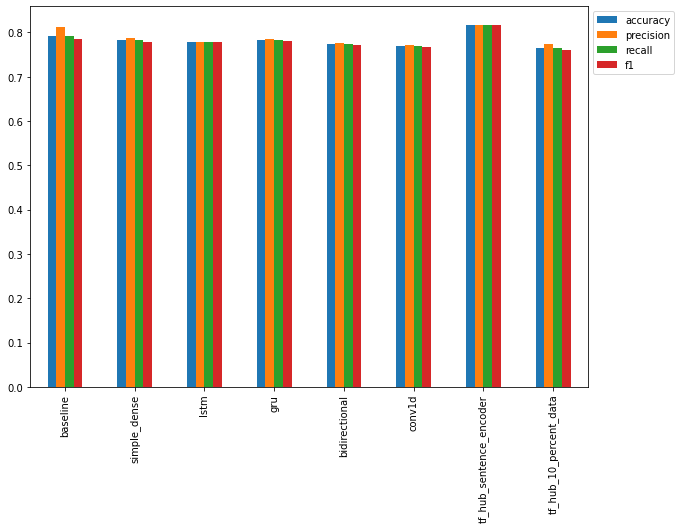

In [101]:
# Doƒüruluƒüu diƒüer metriklerle aynƒ± √∂l√ßeƒüe indirin
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

√ñnceden eƒüitilmi≈ü USE TensorFlow Hub modellerimiz en iyi performansa sahip gibi g√∂r√ºn√ºyor, eƒüitim verilerinin yalnƒ±zca %10'una sahip olan model bile diƒüer modellerden daha iyi performans g√∂steriyor. Bu, transfer √∂ƒürenmenin g√ºc√ºn√º g√∂sterir.

Detaylara inip her modelin F1 puanlarƒ±nƒ± almaya ne dersiniz?

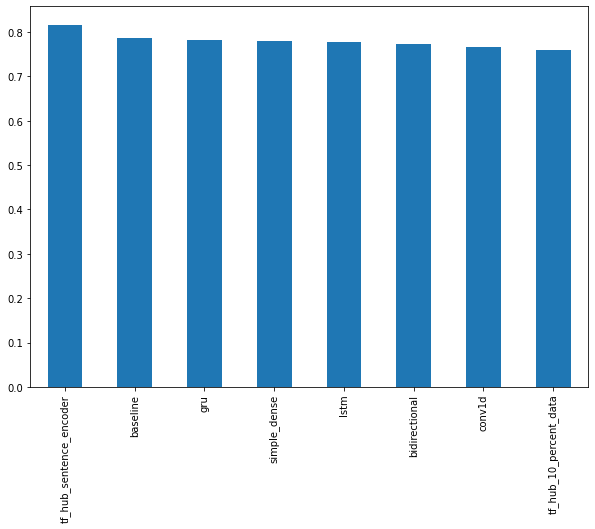

In [102]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Tek bir √∂l√ß√ºmde detaya indiƒüimizde, USE TensorFlow Hub modellerimizin diƒüer t√ºm modellerden daha iyi performans g√∂sterdiƒüini g√∂r√ºyoruz. ƒ∞lgin√ß bir ≈üekilde, temelin F1 puanƒ±, daha derin modellerin geri kalanƒ±ndan √ßok uzakta deƒüil.

## Modellerimizi Birle≈ütirmek

Bir√ßok √ºretim sistemi, bir tahmin yapmak i√ßin bir **ensemble** (birden √ßok farklƒ± modelin bir araya getirilmesi) modellerini kullanƒ±r.

Model istiflemenin ardƒ±ndaki fikir, birbiriyle ili≈ükisiz birka√ß modelin bir tahmin √ºzerinde anla≈ümaya varmasƒ± durumunda, tahminin tekil bir model tarafƒ±ndan yapƒ±lan bir tahminden daha saƒülam olmasƒ± gerektiƒüidir.

Yukarƒ±daki c√ºmledeki anahtar kelime ** uncorrelated**, bu da farklƒ± model t√ºrleri demenin ba≈üka bir yoludur. √ñrneƒüin, bizim durumumuzda taban √ßizgimizi, √ßift y√∂nl√º modelimizi ve TensorFlow Hub USE modelimizi birle≈ütirebiliriz.

Bu modellerin hepsi aynƒ± veriler √ºzerinde eƒüitilmi≈ü olsa da, hepsinin farklƒ± bir kalƒ±p bulma yolu vardƒ±r.

√ú√ß LSTM modeli gibi benzer ≈üekilde eƒüitilmi≈ü √º√ß model kullanacak olsaydƒ±k, √ßƒ±ktƒ± tahminleri muhtemelen √ßok benzer olacaktƒ±r.

Bunu arkada≈ülarƒ±nƒ±zla nerede yemek yiyeceƒüinize karar vermeye √ßalƒ±≈ümak olarak d√º≈ü√ºn√ºn. Hepinizin zevkleri benzerse, muhtemelen hepiniz aynƒ± restoranƒ± se√ßeceksiniz. Ama hepinizin farklƒ± zevkleri varsa ve yine de aynƒ± restoranƒ± se√ßerseniz, restoran iyi olmalƒ±.

Bir sƒ±nƒ±flandƒ±rma problemi ile √ßalƒ±≈ütƒ±ƒüƒ±mƒ±z i√ßin modellerimizi birle≈ütirmenin birka√ß yolu vardƒ±r:
1. **Ortalama** - Her √∂rnek i√ßin her modelin √ßƒ±ktƒ± tahmin olasƒ±lƒ±klarƒ±nƒ± alƒ±n, birle≈ütirin ve ardƒ±ndan ortalamasƒ±nƒ± alƒ±n.
2. **√áoƒüunluk oyu (mod)** - Modellerinizin her biri ile t√ºm √∂rneklerde sƒ±nƒ±f tahminleri yapƒ±n, tahmin edilen sƒ±nƒ±f √ßoƒüunlukta olandƒ±r. √ñrneƒüin, √º√ß farklƒ± model sƒ±rasƒ±yla `[1, 0, 1]` deƒüerini tahmin ederse, √ßoƒüunluk sƒ±nƒ±fƒ± `1` olur, bu nedenle bu tahmin edilen etiket olacaktƒ±r.
3. **Model yƒ±ƒüƒ±nlama** - Se√ßtiƒüiniz modellerin her birinin √ßƒ±ktƒ±larƒ±nƒ± alƒ±n ve bunlarƒ± ba≈üka bir modele girdi olarak kullanƒ±n.

> üìñ **Kaynak:** Model istifleme/birle≈ütirme i√ßin yukarƒ±daki y√∂ntemler, Andriy Burkov tarafƒ±ndan [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) B√∂l√ºm 6'dan uyarlanmƒ±≈ütƒ±r. Makine √∂ƒürenimi m√ºhendisliƒüi alanƒ±na girmek, yalnƒ±zca modeller olu≈üturmak deƒüil, aynƒ± zamanda √ºretim √∂l√ßeƒüinde makine √∂ƒürenimi sistemleri kurmak istiyorsanƒ±z, tamamƒ±nƒ± okumanƒ±zƒ± ≈üiddetle tavsiye ederim.

Yine, model istifleme kavramƒ± en iyi eylemde g√∂r√ºl√ºr.

Temel modelimizi (`model_0`), LSTM modelimizi (`model_2`) ve tam eƒüitim verisi (`model_6`) √ºzerinde eƒüitilmi≈ü USE modelimizi, her birinin birle≈üik tahmin olasƒ±lƒ±klarƒ±nƒ±n ortalamasƒ±nƒ± alarak birle≈ütireceƒüiz.

In [107]:
# temel modelden tahmin olasƒ±lƒ±klarƒ±nƒ± alƒ±n
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
# tahmin sƒ±nƒ±flarƒ± i√ßin olasƒ±lƒ±klarƒ±nƒ± ortalamasƒ±nƒ± alƒ±n ve yuvarlayƒ±n
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Olaƒüan√ºst√º! Farklƒ± sƒ±nƒ±flardan olu≈üan birle≈ütirilmi≈ü bir tahminler dizimiz var, bunlarƒ± ger√ßek etiketlere g√∂re deƒüerlendirelim ve yƒ±ƒüƒ±lmƒ±≈ü modelimizin sonu√ßlarƒ±nƒ± `all_model_results` DataFrame'imize ekleyelim.

In [108]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 77.95275590551181,
 'f1': 0.7799385559623664,
 'precision': 0.7827644591301087,
 'recall': 0.7795275590551181}

In [109]:
# Birle≈ütirilmi≈ü modelimizin sonu√ßlarƒ±nƒ± DataFrame sonu√ßlarƒ±na ekleyin
all_model_results.loc["ensemble_results"] = ensemble_results
# Doƒüruluƒüu, sonu√ßlarƒ±n geri kalanƒ±yla aynƒ± √∂l√ßeƒüe d√∂n√º≈üt√ºr√ºn
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

all_model_results

accuracy  precision    recall        f1
baseline                 0.792651   0.811139  0.792651  0.786219
simple_dense             0.782152   0.786845  0.782152  0.779088
lstm                     0.778215   0.778385  0.778215  0.778288
gru                      0.783465   0.785557  0.783465  0.781439
bidirectional            0.774278   0.775989  0.774278  0.772231
conv1d                   0.769029   0.770603  0.769029  0.766934
tf_hub_sentence_encoder  0.817585   0.817793  0.817585  0.816933
tf_hub_10_percent_data   0.765092   0.774665  0.765092  0.759687
ensemble_results         0.779528   0.782764  0.779528  0.779939

Yƒ±ƒüƒ±lmƒ±≈ü model diƒüer modellere kar≈üƒ± nasƒ±l bir sonu√ß verdi?

> üîë **Not:** Modelimizin sonu√ßlarƒ±nƒ±n √ßoƒüu benzer g√∂r√ºn√ºyor. Bu, verilerimizden √∂ƒürenilebileceklerin bazƒ± sƒ±nƒ±rlamalarƒ± olduƒüu anlamƒ±na gelebilir. Modelleme denemelerinizin √ßoƒüu benzer sonu√ßlar verdiƒüinde, verilerinizi tekrar g√∂zden ge√ßirmek iyi bir fikirdir.

## Eƒüitilmi≈ü Bir Modeli Kaydetme ve Y√ºkleme

Eƒüitim s√ºresi √ßok uzun s√ºrmese de, yeniden eƒüitmek zorunda kalmamak i√ßin eƒüitilmi≈ü modellerinizi kaydetmek iyi bir uygulamadƒ±r.

Modellerinizi kaydetmek, aynƒ± zamanda, bir web uygulamasƒ±nda olduƒüu gibi, diz√ºst√º bilgisayarƒ±nƒ±zƒ±n dƒ±≈üƒ±nda ba≈üka bir yerde kullanmak √ºzere dƒ±≈üa aktarmanƒ±za da olanak tanƒ±r.

[TensorFlow'da bir modeli kaydetmenin] iki ana yolu vardƒ±r(https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. `HDF5` bi√ßimi.
2. `Kayƒ±tlƒ±Model` bi√ßimi (varsayƒ±lan).

ƒ∞kisine de bir g√∂z atalƒ±m.

In [110]:
model_6.save("model_6.h5")

Bir modeli `HDF5` olarak kaydederseniz, tekrar y√ºklerken TensorFlow'a kullandƒ±ƒüƒ±nƒ±z √∂zel nesneler hakkƒ±nda bilgi vermeniz gerekir.

In [111]:
# Modeli √∂zel Hub Katmanƒ± ile y√ºkleyin (HDF5 formatƒ± i√ßin gereklidir)
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5", 
    custom_objects={"KerasLayer": hub.KerasLayer})

In [112]:
# Y√ºklenen modelimiz nasƒ±l performans g√∂steriyor?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4258 - accuracy: 0.8176


[0.4257993996143341, 0.817585289478302]

Hedef modelimizde `save()` y√∂ntemini √ßaƒüƒ±rmak ve ona bir dosya yolu iletmek, modelimizi `SavedModel` formatƒ±nda kaydetmemizi saƒülar.

In [113]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


SavedModel bi√ßimini (varsayƒ±lan) kullanƒ±rsanƒ±z, `tensorflow.keras.models.load_model()` i≈ülevini kullanarak √∂zel nesneler belirtmeden modelinizi yeniden y√ºkleyebilirsiniz.

In [114]:
# TF Hub C√ºmle Kodlayƒ±cƒ±yƒ± Y√ºkle SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [115]:
# Y√ºklenen SavedModel bi√ßimini deƒüerlendirin
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4258 - accuracy: 0.8176


[0.4257993996143341, 0.817585289478302]

G√∂rd√ºƒü√ºn√ºz gibi, modelimizi her iki formatta da kaydedip y√ºklemek aynƒ± performansƒ± veriyor.

> ü§î **Soru:** "Kayƒ±tlƒ±Model" bi√ßimini mi yoksa "HDF5" bi√ßimini mi kullanmalƒ±sƒ±nƒ±z?

√áoƒüu kullanƒ±m durumu i√ßin `SavedModel` formatƒ± yeterli olacaktƒ±r. Ancak bu, TensorFlow'a √∂zel bir standarttƒ±r. Daha genel ama√ßlƒ± bir veri standardƒ±na ihtiyacƒ±nƒ±z varsa, "HDF5" daha iyi olabilir.

## En Yanlƒ±≈ü √ñrnekleri Bulma

Daha √∂nce bahsetmi≈ütik ki, modelleme deneylerimizin √ßoƒüu, farklƒ± t√ºrde modeller kullanmamƒ±za raƒümen benzer sonu√ßlar veriyorsa, verilere geri d√∂n√ºp bunun neden olabileceƒüini incelemenin iyi bir fikir olduƒüundan bahsetmi≈ütik.

Verilerinizi incelemenin en iyi yollarƒ±ndan biri, modelinizin tahminlerini sƒ±ralamak ve onun en yanlƒ±≈ü yaptƒ±ƒüƒ± √∂rnekleri bulmaktƒ±r, yani hangi tahminlerin y√ºksek tahmin olasƒ±lƒ±ƒüƒ± vardƒ± ama yanlƒ±≈ü √ßƒ±ktƒ±.

Bir kez daha, g√∂rselle≈ütirme sizin arkada≈üƒ±nƒ±zdƒ±r. G√∂rselle≈ütirin, g√∂rselle≈ütirin, g√∂rselle≈ütirin.

ƒ∞≈üleri g√∂rsel hale getirmek i√ßin, en iyi performans g√∂steren modelimizin tahmin olasƒ±lƒ±klarƒ±nƒ± ve sƒ±nƒ±flarƒ±nƒ± doƒürulama √∂rnekleriyle (metin ve kesin doƒüruluk etiketleri) birlikte alalƒ±m ve bunlarƒ± bir panda DataFrame'de birle≈ütirelim.

* En iyi modelimiz hala m√ºkemmel deƒüilse, hangi √∂rnekler yanlƒ±≈ü gidiyor?
* Hangileri en yanlƒ±≈ü?
* Yanlƒ±≈ü olan bazƒ± etiketler var mƒ±? √ñrneƒüin. model doƒüru anlƒ±yor ancak temel doƒüruluk etiketi bunu yansƒ±tmƒ±yor

In [118]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

text  target  pred  pred_prob
0  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0   0.0   0.211150
1  FedEx no longer to transport bioterror germs i...       0   1.0   0.824494
2  Gunmen kill four in El Salvador bus attack: Su...       1   1.0   0.986701
3  @camilacabello97 Internally and externally scr...       1   0.0   0.232937
4  Radiation emergency #preparedness starts with ...       1   1.0   0.771707

≈ûimdi modelimizin yanlƒ±≈ü tahminlerini bulalƒ±m (burada `target != pred`) ve bunlarƒ± tahmin olasƒ±lƒ±klarƒ±na g√∂re sƒ±ralayalƒ±m (`pred_prob` s√ºtunu).

In [119]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

text  target  pred  pred_prob
31   ? High Skies - Burning Buildings ? http://t.co...       0   1.0   0.933326
759  FedEx will no longer transport bioterror patho...       0   1.0   0.906695
628  @noah_anyname That's where the concentration c...       0   1.0   0.883666
49   @madonnamking RSPCA site multiple 7 story high...       0   1.0   0.878714
109  [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...       0   1.0   0.874096
393  @SonofLiberty357 all illuminated by the bright...       0   1.0   0.868922
209  Ashes 2015: Australia¬â√õ¬™s collapse at Trent Br...       0   1.0   0.834798
144                                 The Sound of Arson       0   1.0   0.831975
251  @AshGhebranious civil rights continued in the ...       0   1.0   0.826876
1    FedEx no longer to transport bioterror germs i...       0   1.0   0.824494

Son olarak, √∂rnek metni, doƒüruluk etiketini, tahmin sƒ±nƒ±fƒ±nƒ± ve tahmin olasƒ±lƒ±ƒüƒ±nƒ± g√∂rselle≈ütirmek i√ßin bazƒ± kodlar yazabiliriz. √ñrneklerimizi tahmin olasƒ±lƒ±ƒüƒ±na g√∂re sƒ±raladƒ±ƒüƒ±mƒ±z i√ßin, `en yanlƒ±≈ü` DataFrame'imizin ba≈üƒ±ndaki √∂rneklere bakmak bize yanlƒ±≈ü pozitifler g√∂sterecektir.

Bir hatƒ±rlatƒ±cƒ±:
* `0` = Ger√ßek bir felaket Tweet deƒüil
* `1` = Ger√ßek felaket Tweet

In [120]:
for row in most_wrong[:10].itertuples(): 
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9333264827728271
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9066951870918274
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8836658596992493
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.878714382648468
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8740962147712708
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.8689219355583191
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8347980976

In [121]:
# En yanlƒ±≈ü yanlƒ±≈ü negatifleri kontrol edin (model 1 tahmin etmeliyken 0 tahmin etti)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.07638642191886902
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.06680670380592346
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.06613775342702866
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06331083923578262
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.060991670936346054
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04729391261935234
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 

En yanlƒ±≈ü √∂rneklerle ilgili ilgin√ß bir ≈üey fark ettiniz mi? Etiketler doƒüru mu? Geri d√∂n√ºp olmayan etiketleri d√ºzeltirsek ne olur sizce?

## Test Veri Seti √úzerinde Tahminler Yapmak

Pekala, modelimizin doƒürulama setinde nasƒ±l performans g√∂sterdiƒüini g√∂rd√ºk. Peki ya test veri seti?

Test veri seti i√ßin etiketlerimiz yok, bu y√ºzden bazƒ± tahminler yapmamƒ±z ve bunlarƒ± kendimiz incelememiz gerekecek. Test veri setinden rastgele √∂rnekler √ºzerinde tahminler yapmak i√ßin bazƒ± kodlar yazalƒ±m ve g√∂rselle≈ütirelim.

In [126]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 1, Prob: 0.5674287676811218
Text:
Marin Sr37 / Sr121 **Trfc Collision-Unkn Inj** http://t.co/yqJVEVhSzx

----

Pred: 0, Prob: 0.18044838309288025
Text:
Sometimes blood ain't no thicker than water and sometimes family will bring you down quicker than strangers ???????

----

Pred: 1, Prob: 0.9360947608947754
Text:
Agricultural Buildings on Fire - Aldwark - NYorks Fire &amp; Rescue Service 

Still grim news but fewer piglets caught up http://t.co/0kjCWG6pN9

----

Pred: 1, Prob: 0.936579704284668
Text:
See how a judge ruled in this 2009 accident at #JFK Airport? involving Korean Air?.

http://t.co/Yh1cGlN3rl http://t.co/6F5ShPKjOB

----

Pred: 0, Prob: 0.09350459277629852
Text:
@FollowerOfDole 'Give me your lunch money ner-' *flattened by falling quarter*

----

Pred: 0, Prob: 0.04109868034720421
Text:
100  1' MIX NEW FLAT DOUBLE SIDED LINERLESS BOTTLE CAPS YOU CHOOSE MIX FLATTENED - Full re¬â√õ_ http://t.co/61fALvOCuK http://t.co/1MuTpFcgDL

----

Pred: 1, Prob: 0.6397950649261475

Modelinizin g√∂r√ºnmeyen veriler √ºzerinde nasƒ±l performans g√∂sterdiƒüine ve ardƒ±ndan ger√ßek testte nasƒ±l performans g√∂sterebileceƒüine bir g√∂z atmak i√ßin bu t√ºr g√∂rselle≈ütirme kontrollerini m√ºmk√ºn olduƒüunca sƒ±k yapmak √∂nemlidir.

## Hƒ±z/Puan Dengesi

Yapacaƒüƒ±mƒ±z son testlerden biri, en iyi modelimiz ve temel modelimiz arasƒ±ndaki hƒ±z/puan dengelerini bulmaktƒ±r.

Bu neden √∂nemli?

Deneme yoluyla bulduƒüunuz en iyi performans g√∂steren modeli se√ßmek cazip gelse de, bu model aslƒ±nda bir √ºretim ortamƒ±nda √ßalƒ±≈ümayabilir.

Bu ≈üekilde ifade edin, Twitter olduƒüunuzu ve saatte 1 milyon Tweet aldƒ±ƒüƒ±nƒ±zƒ± hayal edin (bu uydurma bir sayƒ±dƒ±r, ger√ßek sayƒ± √ßok daha y√ºksektir). Ve Tweet'leri okumak ve bir felaketle ilgili ayrƒ±ntƒ±larƒ± ger√ßek zamanlƒ±ya yakƒ±n bir ≈üekilde yetkilileri uyarmak i√ßin bir felaket algƒ±lama sistemi olu≈üturmaya √ßalƒ±≈üƒ±yorsunuz.

ƒ∞≈ülem g√ºc√º √ºcretsiz deƒüildir, bu nedenle proje i√ßin tek bir i≈ülem makinesiyle sƒ±nƒ±rlƒ±sƒ±nƒ±z. Bu makinede, modellerinizden biri %80 doƒürulukla saniyede 10.000 tahminde bulunurken, modellerinizden biri (daha b√ºy√ºk bir model) %85 doƒürulukla saniyede 100 tahmin yapar.

Hangi modeli se√ßersiniz?

ƒ∞kinci modelin performans artƒ±≈üƒ±, ekstra kapasiteyi ka√ßƒ±rmaya deƒüer mi? Tabii ki burada deneyebileceƒüiniz bir√ßok se√ßenek var, ilk modele m√ºmk√ºn olduƒüunca √ßok Tweet g√∂ndermek ve ardƒ±ndan modelin en az emin olduƒüu ≈üeyleri ikinci modele g√∂ndermek gibi.

Buradaki ama√ß, deney yoluyla bulduƒüunuz en iyi modeli g√∂stermektir, √ºretimde kullandƒ±ƒüƒ±nƒ±z model olmayabilir.

Bunu daha somut hale getirmek i√ßin, bir model ve bir dizi √∂rnek alacak bir fonksiyon yazalƒ±m.

In [127]:
import time
def pred_timer(model, samples):
  start_time = time.perf_counter() 
  model.predict(samples) 
  end_time = time.perf_counter() 
  total_time = end_time-start_time 
  time_per_pred = total_time/len(val_sentences)
  return total_time, time_per_pred

ƒ∞yi g√∂r√ºn√ºyor!

≈ûimdi en iyi performans g√∂steren modelimizin (`model_6`) ve temel modelimizin (`model_0`) tahmin s√ºrelerini deƒüerlendirmek i√ßin `pred_timer()` fonksiyonumuzu kullanalƒ±m.

In [128]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.22613020000062534, 0.00029675879265173927)

In [129]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.016506090001712437, 2.1661535435318158e-05)

Mevcut donanƒ±mƒ±mƒ±zla (benim durumumda bir Google Colab not defteri kullanƒ±yorum) en iyi performans g√∂steren modelimiz, temel modelimiz olarak tahminler yapmak i√ßin 10 kat daha fazla zaman alƒ±yor. Bu ekstra tahmin s√ºresi buna deƒüer mi?

Modelimizin F1 puanlarƒ±yla tahmin ba≈üƒ±na s√ºreyi kar≈üƒ±la≈ütƒ±ralƒ±m.

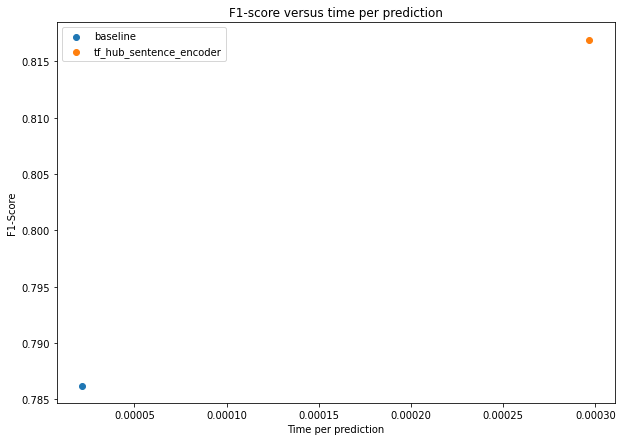

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

Elbette, bu noktalarƒ±n her biri i√ßin ideal konum, grafiƒüin sol √ºst k√∂≈üesinde olmaktƒ±r (tahmin ba≈üƒ±na d√º≈ü√ºk s√ºre, y√ºksek F1 puanƒ±).

Bizim durumumuzda, tahmin ve performans ba≈üƒ±na s√ºre i√ßin a√ßƒ±k bir fark var. En iyi performans g√∂steren modelimiz, tahmin ba≈üƒ±na bir b√ºy√ºkl√ºk sƒ±rasƒ± daha uzun s√ºr√ºyor, ancak yalnƒ±zca birka√ß F1 puanƒ± artƒ±≈üƒ±yla sonu√ßlanƒ±yor.

Bu t√ºr bir fark, makine √∂ƒürenimi modellerini kendi uygulamalarƒ±nƒ±za dahil ederken aklƒ±nƒ±zda bulundurmanƒ±z gereken bir ≈üeydir.